# Project Garble
## Speech information summarizer for lecture videos

## Setup

### Imports

In [1]:
% matplotlib inline

from IPython.display import HTML, display, Markdown
import os
import datasets
from datasets import load_metric
import pathlib
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import pytextrank
import spacy
import ast
import json

### Declarations

In [2]:
os.chdir("../")
# !make install

In [3]:

RAW_SUMMARIZATION_DATASETS_DIR = "datasets/raw/supervised/summarization"
RAW_SUMMARIZATION_DATASETS_BUCKET_DIR = "https://storage.googleapis.com/ac215-project-garble-bucket/datasets/raw/supervised/summarization"

## Exploratory Data Analysis (EDA)

In [4]:
##https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad

def count_sentences(examples):
    return {
        "document_sentence_count": [len(document) for document in examples["document"]],
        "summary_sentence_count": [len(document) for document in examples["summary"]],
    }


def count_words(examples):
    return {
        "document_word_count": [sum(len(item.split()) for item in document) for document in examples["document"]],
        "summary_word_count": [sum(len(item.split()) for item in document) for document in examples["summary"]],
    }


def count_chars(examples):
    return {
        "document_char_count": [sum(len("".join(item.split())) for item in document) for document in
                                examples["document"]],
        "summary_char_count": [sum(len("".join(item.split())) for item in document) for document in
                               examples["summary"]],
    }


def sentence_density(examples):
    return {
        "document_sentence_density": [document[0] / (document[1] if document[1] else 1) for document in
                                      zip(examples["document_sentence_count"], examples["document_word_count"])],
        "summary_sentence_density": [document[0] / (document[1] if document[1] else 1) for document in
                                     zip(examples["summary_sentence_count"], examples["summary_word_count"])],
    }


def _count_stopwords(text, stopwords=STOPWORDS):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    stopwords_x = [w for w in "\n".join(text).split() if w.lower() in stopwords]

    return len(stopwords_x)


def count_stopwords(examples):
    return {
        "document_stopword_count": [_count_stopwords(document) for document in examples["document"]],
        "summary_stopword_count": [_count_stopwords(document) for document in examples["summary"]]
    }


def load_dataset_stats(dataset):
    features = datasets.features.Features({
        'document': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
        'summary': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
    })
    dataset_name, splits = dataset

    dataset = datasets.load_dataset("json", dataset_name, data_files=splits, features=features, )
    removed_cols = list(set(column_name for sublist in dataset.values() for column_name in sublist.column_names))

    datasets_info = (
        dataset
            .map(count_sentences, batched=True)
            .map(count_words, batched=True, )
            .map(count_chars, batched=True)
            .map(sentence_density, batched=True)
            .map(count_stopwords, batched=True, remove_columns=removed_cols)
    )

    return datasets_info


def load_data_splits_from_dir(directory, ext="json.gz"):
    splits = defaultdict(dict)
    directory_files = pathlib.Path(directory).glob(f"**/*.{ext}")
    for file_path in directory_files:
        data_split = file_path.stem.split(".")[0]
        splits[file_path.parent.stem][data_split] = str(file_path.resolve())
    return dict(splits)


def load_splits_from_bucket_dir(base_path):
    splits = defaultdict(dict)
    dataset_names = ["ami", "cc_news", "cnn_dailymail", "icsi", "mediasumm", "spotify", "ted", "xsum"]
    split_names = ["train", "valid", "test"]
    for name in dataset_names:
        for split in split_names:
            splits[name][split] = f"{base_path}/{name}/{split}.json.gz"
    return dict(splits)



In [5]:
def save_dataset_infos(datadir):
    data_splits = load_splits_from_bucket_dir(datadir)
    for dataset in tqdm(data_splits.items()):
        ## TODO Write Dataset loading script
        # https://huggingface.co/docs/datasets/v1.12.0/dataset_script.html
        dataset_info = load_dataset_stats(dataset)
        dataset_name, _ = dataset
        for split_name, split_info in dataset_info.items():
            outfile = pathlib.Path(RAW_SUMMARIZATION_DATASETS_DIR).joinpath(dataset_name,
                                                                            f"{split_name}_info.csv").resolve()
            split_df = split_info.to_pandas()
            split_df.to_csv(outfile, index=False, index_label=False)

# save_dataset_infos(RAW_SUMMARIZATION_DATASETS_BUCKET_DIR)

In [6]:
def show_dataset_samples(datadir):
    features = datasets.features.Features({
        'document': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
        'summary': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
    })
    data_splits = load_splits_from_bucket_dir(datadir)
    for dataset in tqdm(data_splits.items()):
        dataset_name, splits = dataset
        dataset = datasets.load_dataset("json", dataset_name, data_files=splits, features=features, )
        print(json.dumps(dataset['train'][0]))

In [ ]:
# show_dataset_samples(RAW_SUMMARIZATION_DATASETS_BUCKET_DIR)

In [7]:
def make_kdeplot(dataset, x_col, hue_col, ax):
    sns.kdeplot(
        data=dataset, x=x_col, hue=hue_col,
        fill=True, common_norm=False, palette="crest", ax=ax,
        alpha=.5, linewidth=0)


def make_boxplot(dataset, x_col, y_col, ax):
    sns.boxplot(
        data=dataset, y=y_col, x=x_col, palette="crest",
        dodge=False, orient="v", ax=ax)


def show_data_dists(dataset, name):
    _, ax = plt.subplots(nrows=4, ncols=4, figsize=(25, 15))
    make_kdeplot(dataset, x_col="document_sentence_count", hue_col="split", ax=ax[0][0])
    make_kdeplot(dataset, x_col="document_word_count", hue_col="split", ax=ax[0][1])
    make_kdeplot(dataset, x_col="document_char_count", hue_col="split", ax=ax[0][2])
    make_kdeplot(dataset, x_col="document_stopword_count", hue_col="split", ax=ax[0][3])

    make_boxplot(dataset, x_col="split", y_col="document_sentence_count", ax=ax[1][0])
    make_boxplot(dataset, x_col="split", y_col="document_word_count", ax=ax[1][1])
    make_boxplot(dataset, x_col="split", y_col="document_char_count", ax=ax[1][2])
    make_boxplot(dataset, x_col="split", y_col="document_stopword_count", ax=ax[1][3])

    make_kdeplot(dataset, x_col="summary_sentence_count", hue_col="split", ax=ax[2][0])
    make_kdeplot(dataset, x_col="summary_word_count", hue_col="split", ax=ax[2][1])
    make_kdeplot(dataset, x_col="summary_char_count", hue_col="split", ax=ax[2][2])
    make_kdeplot(dataset, x_col="summary_stopword_count", hue_col="split", ax=ax[2][3])

    make_boxplot(dataset, x_col="split", y_col="summary_sentence_count", ax=ax[3][0])
    make_boxplot(dataset, x_col="split", y_col="summary_word_count", ax=ax[3][1])
    make_boxplot(dataset, x_col="split", y_col="summary_char_count", ax=ax[3][2])
    make_boxplot(dataset, x_col="split", y_col="summary_stopword_count", ax=ax[3][3])

    plt.suptitle(f"Descriptive Statistics for {name} Dataset", fontsize=20)
    plt.tight_layout()
    plt.show()

In [8]:
def load_visualizations_and_stats(datadir):
    info_splits = load_data_splits_from_dir(datadir, ext="csv")
    descriptions = []
    for name, splits in info_splits.items():
        dataset_subset = []
        dataset_subset_description = []
        for split, fname in splits.items():
            data_info = pd.read_csv(fname)
            split = split.split('_')[0]
            description = data_info.describe().T
            description = description.set_index(pd.MultiIndex.from_tuples(
                [(name, split, col.split("_")[0], "_".join(col.split("_")[1:])) for col in description.index]))
            descriptions.append(description)

            data_info["dataset"] = name
            data_info["split"] = split

            dataset_subset.append(data_info)
            dataset_subset_description.append(description)

        ## display the described dataframe for each dataset
        dataset_subset_description = pd.concat(dataset_subset_description)
        dataset_subset = pd.concat(dataset_subset).reset_index(drop=True)
        yield dataset_subset, name, dataset_subset_description
    descriptions = pd.concat(descriptions, axis=0)
    return descriptions

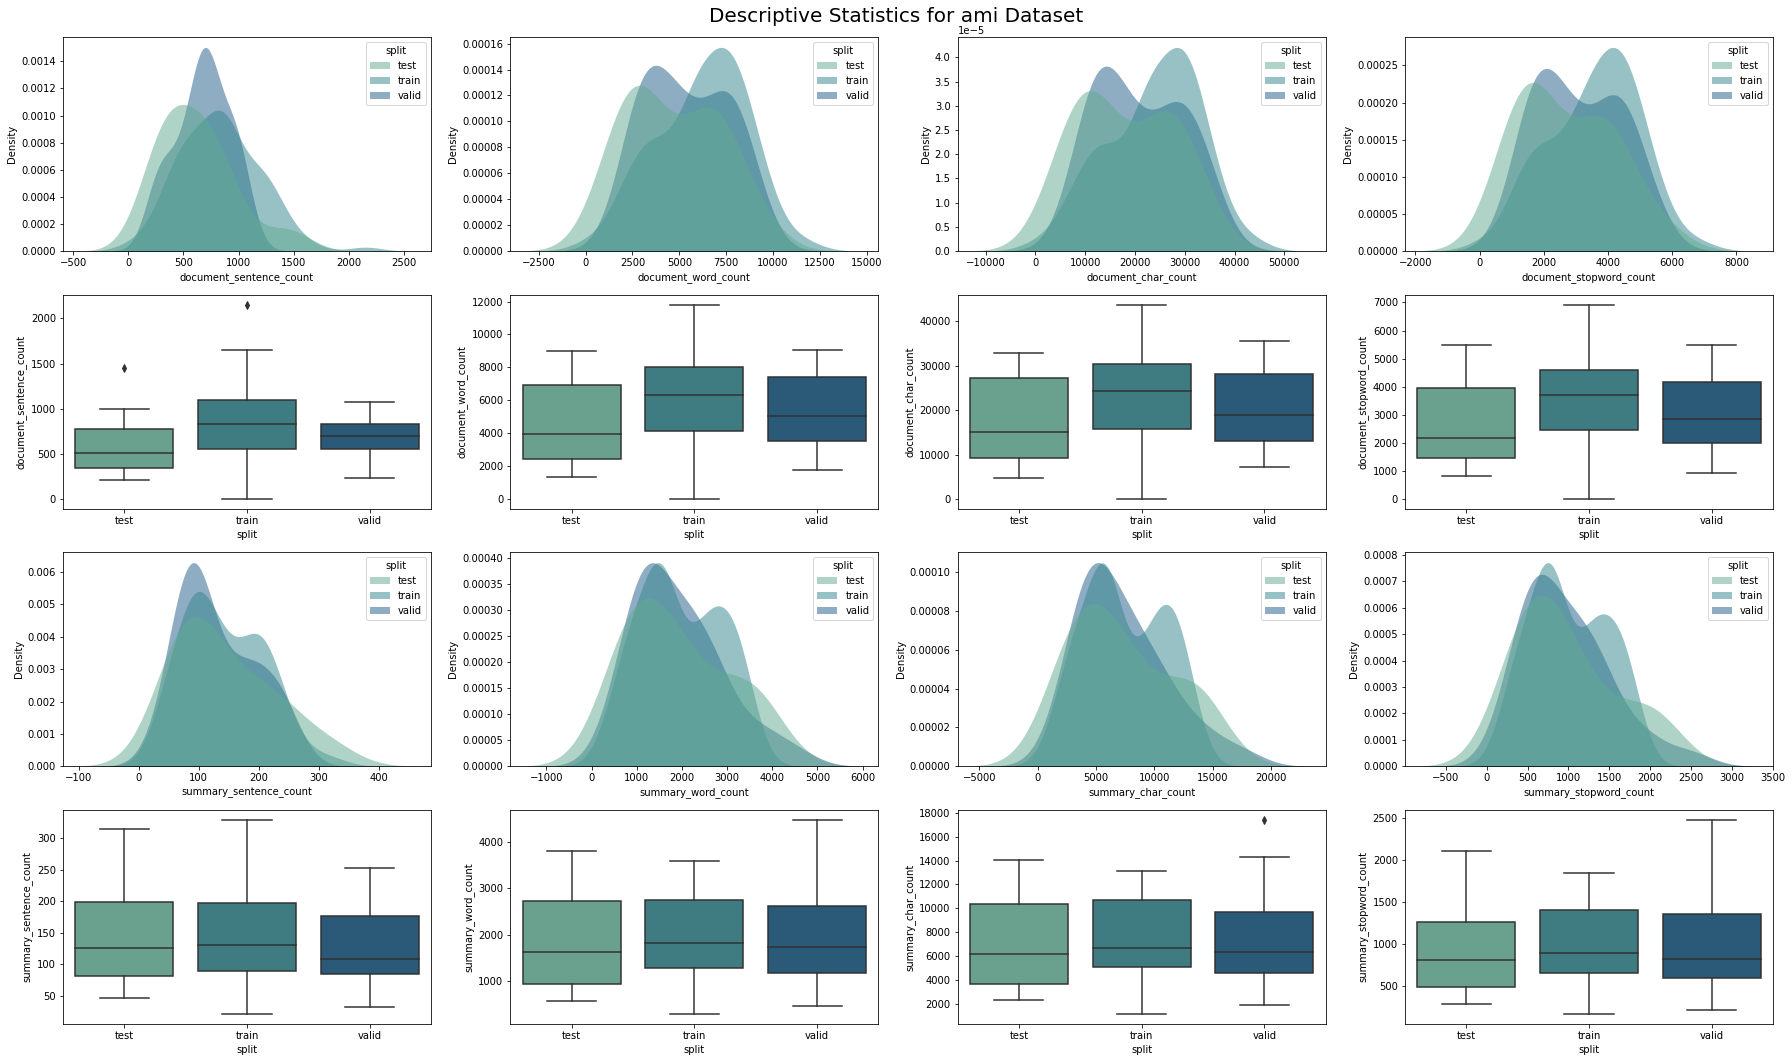

count     mean     std     min      25%  \
ami test  document char_count        13.00 18087.08 9478.36 4770.00  9311.00   
                   sentence_count    13.00   619.23  343.82  215.00   345.00   
                   sentence_density  13.00     0.13    0.02    0.11     0.13   
                   stopword_count    13.00  2702.31 1466.85  827.00  1468.00   
                   word_count        13.00  4698.77 2481.55 1326.00  2445.00   
          summary  char_count        13.00  7275.15 4277.15 2269.00  3670.00   
                   sentence_count    13.00   142.31   81.20   47.00    82.00   
                   sentence_density  13.00     0.08    0.01    0.06     0.07   
                   stopword_count    13.00   979.15  603.34  289.00   485.00   
                   word_count        13.00  1908.54 1116.73  578.00   950.00   
    train document char_count        95.00 23670.63 9216.79    0.00 15814.00   
                   sentence_count    95.00   830.88  366.41    0.00   554.50   
                   sentence_density  95.00     0.13    0.03    0.00     0.12   
                   stopword_count    95.00  3557.26 1403.14    0.00  2461.50   
                   word_count        95.00  6177.65 2420.14    0.00  4152.50   
          summary  char_count        95.00  7443.33 3404.71 1113.00  5028.00   
                   sentence_count    95.00   142.48   67.08   21.00    89.00   
                   sentence_density  95.00     0.07    0.01    0.05     0.06   
                   stopword_count    95.00  1007.49  464.00  165.00   655.00   
                   word_count        95.00  1964.75  890.51  299.00  1279.50   
    valid document char_count        29.00 20877.34 8637.88 7108.00 13066.00   
                   sentence_count    29.00   674.86  241.03  234.00   558.00   
                   sentence_density  29.00     0.13    0.02    0.09     0.12   
                   stopword_count    29.00  3087.34 1311.04  922.00  1979.00   
                   word_count        29.00  5397.00 2202.61 1776.00  3529.00   
          summary  char_count        29.00  7264.62 3791.94 1895.00  4547.00   
                   sentence_count    29.00   130.97   62.84   33.00    84.00   
                   sentence_density  29.00     0.07    0.01    0.05     0.06   
                   stopword_count    29.00   972.52  536.52  208.00   594.00   
                   word_count        29.00  1904.69  982.88  469.00  1181.00   

                                         50%      75%      max  
ami test  document char_count       15164.00 27179.00 32859.00  
                   sentence_count     506.00   774.00  1450.00  
                   sentence_density     0.14     0.14     0.16  
                   stopword_count    2157.00  3942.00  5496.00  
                   word_count        3952.00  6903.00  9014.00  
          summary  char_count        6161.00 10341.00 14079.00  
                   sentence_count     126.00   199.00   314.00  
                   sentence_density     0.08     0.08     0.10  
                   stopword_count     809.00  1265.00  2105.00  
                   word_count        1626.00  2729.00  3803.00  
    train document char_count       24253.00 30462.50 43824.00  
                   sentence_count     825.00  1092.50  2154.00  
                   sentence_density     0.13     0.15     0.20  
                   stopword_count    3689.00  4590.00  6928.00  
                   word_count        6301.00  8010.50 11822.00  
          summary  char_count        6702.00 10689.50 13157.00  
                   sentence_count     131.00   197.50   329.00  
                   sentence_density     0.07     0.08     0.11  
                   stopword_count     893.00  1407.50  1842.00  
                   word_count        1820.00  2742.00  3581.00  
    valid document char_count       19001.00 28225.00 35602.00  
                   sentence_count     699.00   826.00  1076.00  
                   sentence_density     0.12     0.14     0.1

# Dataset Card AMI Dataset

## Dataset Description

- **Homepage:** https://groups.inf.ed.ac.uk/ami/corpus/
- **Repository:** https://github.com/gcunhase/AMICorpusXML
- **Paper:** https://groups.inf.ed.ac.uk/ami/corpus/overview.shtml


### Dataset Summary

The AMI Meeting Corpus consists of 100 hours of meeting recordings. The recordings use a range of signals synchronized to a common timeline. These include close-talking and far-field microphones, individual and room-view video cameras, and output from a slide projector and an electronic whiteboard. During the meetings, the participants also have unsynchronized pens available to them that record what is written. The meetings were recorded in English using three different rooms with different acoustic properties, and include mostly non-native speakers.

The AMI Meeting Corpus includes high quality, manually produced orthographic transcription for each individual speaker, including word-level timings that have derived by using a speech recognizer in forced alignment mode. It also contains a wide range of other annotations, not just for linguistic phenomena but also detailing behaviours in other modalities. These include dialogue acts; topic segmentation; extractive and abstractive summaries; named entities; the types of head gesture, hand gesture, and gaze direction that are most related to communicative intention; movement around the room; emotional state; and where heads are located on the video frames. The linguistically motivated annotations have been applied the most widely, and cover all of the scenario-based recordings. Other annotations are more limited, but in each case we have chosen what we consider a sensible data subset. For phenomena that are sparse in the meeting recordings, we have marked up auxiliary recordings where the behaviours are more common. These are also included in the corpus.

### Supported Tasks and Model Mesaurement


**Extractive and Abstractive Summarization**: The dataset can be used to train a model for Extractive and Abstractive summarization, which consists, select key sentences and phrases from the document and combine them into shorter forms and Abstractive summarization tries to understand the main content of the document and then explain them in clear natural language. Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(metric)).

### Languages

American English


## Dataset Structure

### Data Instances



```
<data>
    <items>
        <item name="item1">item1abc</item>
        <item name="item2">item2abc</item>
    </items>
</data>
```


### Data Fields

item1 = Description

item2 = Summary



### Data Splits


dataset split into Train, Validation and Test data sets

  For example:

|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |   78934     | 19571   | 8050      |
| Average Sentence Length    |    830    |  630     | 619     |

## Dataset Creation

**Final dataset has below structure**
```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```
### Licensing Information

[License](http://creativecommons.org/licenses/by/4.0/legalcode)

### Citation Information


```
@INPROCEEDINGS{Mccowan05theami,
    author = {I. Mccowan and G. Lathoud and M. Lincoln and A. Lisowska and W. Post and D. Reidsma and P. Wellner},
    title = {The AMI Meeting Corpus},
    booktitle = {In: Proceedings Measuring Behavior 2005, 5th International Conference on Methods and Techniques in Behavioral Research. L.P.J.J. Noldus, F. Grieco, L.W.S. Loijens and P.H. Zimmerman (Eds.), Wageningen: Noldus Information Technology},
    year = {2005}
}
```



**Train Data  Distribution**
-  830 sentences, 6177 words and 7443 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (2154) and chars (more than 13157.00) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are not far from mean value and the standard deviation is relatively  low.
Most summaries are composed by 142 sentence and the number of words is very close to 1964
The number of chars are mostly between 7440 and 7450.
There are few records with large values. Outliers is not a problem, we can remove them.


**Data Visualization**

The count of rows with outliers values is a small number, we can consider removing them but it does not look a great deal. The count of words looks like noraml distribution, 75% of rows in the range 8010 words, 1092 sentences and the count of char is a normal distribution. We do not identify weird examples or data distributions.


In [9]:
visualizations = load_visualizations_and_stats(RAW_SUMMARIZATION_DATASETS_DIR)

dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)

display(Markdown("datasets/raw/supervised/summarization/ami/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/ami/dataset_distribution.md"))

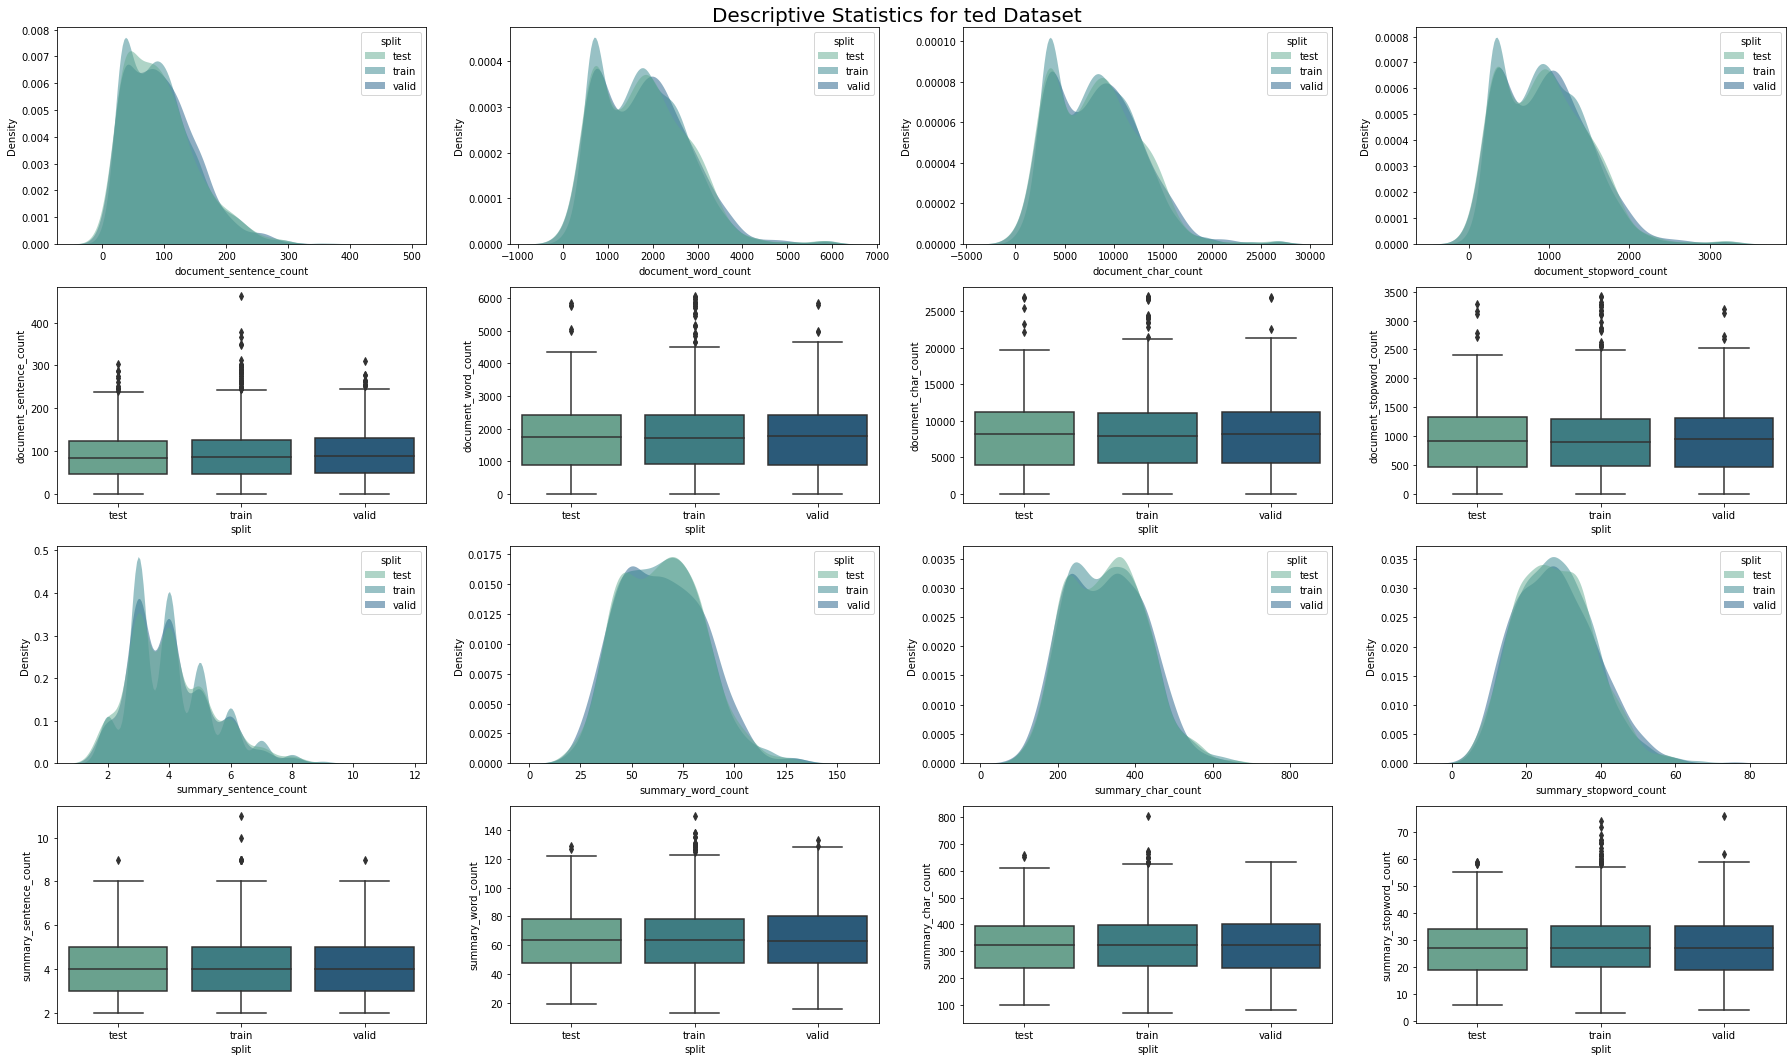

count    mean     std    min     25%  \
ted test  document char_count        606.00 8136.31 4388.51   0.00 3980.75   
                   sentence_count    606.00   92.16   56.46   0.00   47.00   
                   sentence_density  606.00    0.05    0.02   0.00    0.04   
                   stopword_count    606.00  938.66  540.28   0.00  454.00   
                   word_count        606.00 1759.96  975.42   0.00  869.00   
          summary  char_count        606.00  324.36   99.27 101.00  239.00   
                   sentence_count    606.00    4.00    1.34   2.00    3.00   
                   sentence_density  606.00    0.06    0.02   0.03    0.05   
                   stopword_count    606.00   27.53   10.24   6.00   19.00   
                   word_count        606.00   64.11   19.91  19.00   48.00   
    train document char_count       2828.00 8118.03 4260.27   0.00 4227.75   
                   sentence_count   2828.00   93.89   56.87   0.00   47.00   
                   sentence_density 2828.00    0.05    0.01   0.00    0.04   
                   stopword_count   2828.00  937.08  523.82   0.00  476.75   
                   word_count       2828.00 1759.56  949.32   0.00  915.75   
          summary  char_count       2828.00  324.96  100.89  71.00  244.00   
                   sentence_count   2828.00    4.04    1.35   2.00    3.00   
                   sentence_density 2828.00    0.07    0.02   0.03    0.05   
                   stopword_count   2828.00   27.83   10.56   3.00   20.00   
                   word_count       2828.00   64.32   20.34  13.00   48.00   
    valid document char_count        606.00 8218.17 4391.33   0.00 4160.50   
                   sentence_count    606.00   94.48   55.52   0.00   48.00   
                   sentence_density  606.00    0.05    0.02   0.00    0.04   
                   stopword_count    606.00  951.06  540.59   0.00  457.50   
                   word_count        606.00 1782.85  976.19   0.00  878.75   
          summary  char_count        606.00  323.65  100.86  82.00  238.00   
                   sentence_count    606.00    3.97    1.29   2.00    3.00   
                   sentence_density  606.00    0.06    0.02   0.02    0.05   
                   stopword_count    606.00   27.76   10.94   4.00   19.00   
                   word_count        606.00   64.14   20.68  16.00   48.00   

                                        50%      75%      max  
ted test  document char_count       8122.00 11163.00 26916.00  
                   sentence_count     83.00   123.00   304.00  
                   sentence_density    0.05     0.06     0.23  
                   stopword_count    909.00  1323.25  3288.00  
                   word_count       1736.00  2411.75  5852.00  
          summary  char_count        324.00   394.75   659.00  
                   sentence_count      4.00     5.00     9.00  
                   sentence_density    0.06     0.07     0.12  
                   stopword_count     27.00    34.00    59.00  
                   word_count         64.00    78.00   129.00  
    train document char_count       7927.50 11053.50 27054.00  
                   sentence_count     86.00   126.00   461.00  
                   sentence_density    0.05     0.06     0.15  
                   stopword_count    902.00  1296.00  3418.00  
                   word_count       1706.00  2404.00  6060.00  
          summary  char_count        322.00   396.00   804.00  
                   sentence_count      4.00     5.00    11.00  
                   sentence_density    0.06     0.08     0.21  
                   stopword_count     27.00    35.00    74.00  
                   word_count         64.00    78.00   150.00  
    valid document char_count       8127.50 11202.00 26938.00  
                   sentence_count     88.00   129.00   311.00  
                   sentence_density    0.05     0.06     0.36  
                   stopword_count    944.50  1310.00  3192.00  
                   

# Dataset Card Ted Dataset

## Dataset Description

- **Homepage:** [Ted Talk Home](https://www.kaggle.com/rounakbanik/ted-talks)
- **Repository:** [Ted Talk Download](https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Frounakbanik%2Fted-talks%3Fresource%3Ddownload)

### Dataset Summary

These datasets contain information about all audio-video recordings of TED Talks uploaded to the official TED.com website until September 21st, 2017. The TED main dataset contains information about all talks including number of views, number of comments, descriptions, speakers and titles. The TED transcripts dataset contains the transcripts for all talks available on TED.com.

Content
There are two CSV files.

ted_main.csv - Contains data on actual TED Talk metadata and TED Talk speakers.

transcripts.csv - Contains transcript and URL information for TED Talks

Acknowledgements
The data has been scraped from the official TED Website and is available under the Creative Commons License.

Inspiration
I've always been fascinated by TED Talks and the immense diversity of content that it provides for free. I was also thoroughly inspired by a TED Talk that visually explored TED Talks stats and I was motivated to do the same thing, albeit on a much less grander scale.

Some of the questions that can be answered with this dataset:

How is each TED Talk related to every other TED Talk?
Which are the most viewed and most favorited Talks of all time? Are they mostly the same? What does this tell us?
What kind of topics attract the maximum discussion and debate (in the form of comments)?
Which months are most popular among TED and TEDx chapters?
Which themes are most popular amongst TEDsters?

### Supported Tasks and Model Measurement

**Extractive and Abstractive Summarization**: The dataset can be used to train a model for Extractive and Abstractive summarization, which consists, select key sentences and phrases from the document and combine them into shorter forms and Abstractive summarization tries to understand the main content of the document and then explain them in clear natural language. Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(met

### Languages

The dataset is in English language

## Dataset Structure

### Data Instances

Provide an JSON-formatted example and brief description of a typical instance in the dataset. If available, provide a link to further examples.

```
comments	description	duration	event	film_date	languages	main_speaker	name	num_speaker	published_date	ratings	related_talks	speaker_occupation	tags	title	url	views
4553	Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.	1164	TED2006	1140825600	60	Ken Robinson	Ken Robinson: Do schools kill creativity?	1	1151367060	[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]	[{'id': 865, 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg', 'speaker': 'Ken Robinson', 'title': 'Bring on the learning revolution!', 'duration': 1008, 'slug': 'sir_ken_robinson_bring_on_the_revolution', 'viewed_count': 7266103}, {'id': 1738, 'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg', 'speaker': 'Ken Robinson', 'title': "How to escape education's death valley", 'duration': 1151, 'slug': 'ken_robinson_how_to_escape_education_s_death_valley', 'viewed_count': 6657572}, {'id': 2276, 'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg', 'speaker': 'Linda Cliatt-Wayman', 'title': 'How to fix a broken school? Lead fearlessly, love hard', 'duration': 1027, 'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard', 'viewed_count': 1617101}, {'id': 892, 'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb583619a54866c41ef303_2880x1620.jpg', 'speaker': 'Charles Leadbeater', 'title': 'Education innovation in the slums', 'duration': 1138, 'slug': 'charles_leadbeater_on_education', 'viewed_count': 772296}, {'id': 1232, 'hero': 'https://pe.tedcdn.com/images/ted/0e3e4e92d5ee8ae0e43962d447d3f790b31099b8_800x600.jpg', 'speaker': 'Geoff Mulgan', 'title': 'A short intro to the Studio School', 'duration': 376, 'slug': 'geoff_mulgan_a_short_intro_to_the_studio_school', 'viewed_count': 667971}, {'id': 2616, 'hero': 'https://pe.tedcdn.com/images/ted/71cde5a6fa6c717488fb55eff9eef939a9241761_2880x1620.jpg', 'speaker': 'Kandice Sumner', 'title': "How America's public schools keep kids in poverty", 'duration': 830, 'slug': 'kandice_sumner_how_america_s_public_schools_keep_kids_in_poverty', 'viewed_count': 1181333}]	Author/educator	['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']	Do schools kill creativity?	"https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity
"	47227110
```



### Data Fields

- `comments`
-	`description`	
- `duration`
- `event`
- `film_date`
- `languages`
- `main_speaker`
- `name`
- `num_speaker`
- `published_date`	
- `ratings`
- `related_talks`	
- `speaker_occupation`
- `tags`	
- `title`	
- `url`
- `views`

### Data Splits

dataset split into Train, Validation and Test datasets

|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |   265526     |  57254     |   55849   |
| Average Sentence Length    |     93   |  94     |   92   |

## Dataset Creation

### Source Data

Kaggle

#### Who are the source language producers?

audio-video recordings of TED Talks uploaded to the official TED.com 

### Final Data

**Final dataset has below structure**
```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```

### Licensing Information

Copyright (c) 2020 Vishal Gupta

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


**Train Data  Distribution**
-  93 sentences, 1759 words and 7443 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (461) and chars (more than 806) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are close to the mean value and the standard deviation is relatively small.
Most summaries are composed by 4 sentence and the number of words is very close to 64
The number of chars are mostly between 320 and 330.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is a small number, we can consider removing them but it does not look a great deal. The count of words looks like noraml distribution, 75% of rows in the range 78 words, 5 sentences and the count of char is a normal distribution. We do not identify weird examples or data distributions.

In [10]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/ted/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/ted/dataset_distribution.md"))

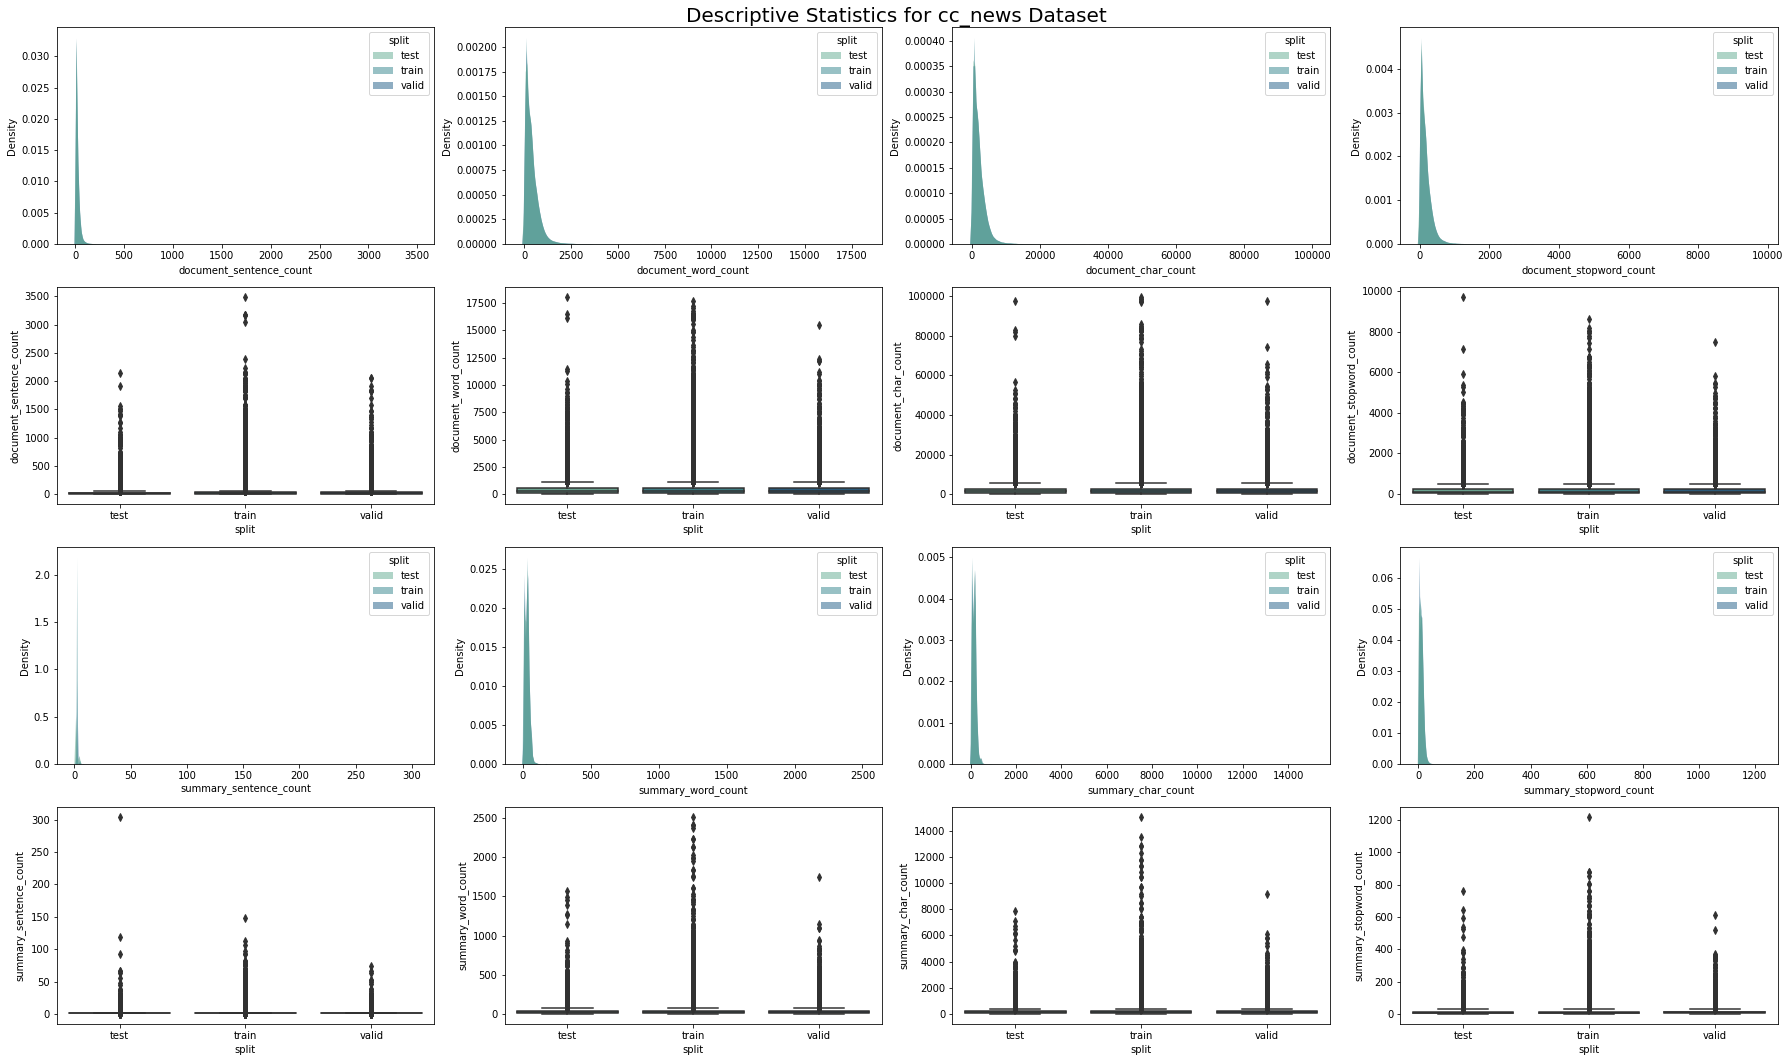

count    mean     std   min  \
cc_news test  document char_count        70825.00 1981.71 2332.45 53.00   
                       sentence_count    70825.00   22.37   38.96  1.00   
                       sentence_density  70825.00    0.06    0.03  0.00   
                       stopword_count    70825.00  169.95  205.72  0.00   
                       word_count        70825.00  395.06  462.74 15.00   
              summary  char_count        70825.00  152.52  150.46  0.00   
                       sentence_count    70825.00    2.08    1.77  0.00   
                       sentence_density  70825.00    0.09    0.06  0.00   
                       stopword_count    70825.00    9.62   11.41  0.00   
                       word_count        70825.00   29.14   28.75  0.00   
        train document char_count       566592.00 1991.58 2364.92 42.00   
                       sentence_count   566592.00   22.48   41.11  1.00   
                       sentence_density 566592.00    0.06    0.03  0.00   
                       stopword_count   566592.00  170.73  207.51  0.00   
                       word_count       566592.00  396.85  468.80 15.00   
              summary  char_count       566592.00  151.82  152.54  0.00   
                       sentence_count   566592.00    2.07    1.31  0.00   
                       sentence_density 566592.00    0.09    0.06  0.00   
                       stopword_count   566592.00    9.58   11.50  0.00   
                       word_count       566592.00   29.00   28.74  0.00   
        valid document char_count        70824.00 2002.13 2396.05 49.00   
                       sentence_count    70824.00   22.78   43.78  1.00   
                       sentence_density  70824.00    0.06    0.03  0.00   
                       stopword_count    70824.00  171.32  207.42  0.00   
                       word_count        70824.00  398.76  472.40 15.00   
              summary  char_count        70824.00  152.43  144.76  0.00   
                       sentence_count    70824.00    2.08    1.26  0.00   
                       sentence_density  70824.00    0.09    0.06  0.00   
                       stopword_count    70824.00    9.64   10.75  0.00   
                       word_count        70824.00   29.13   27.35  0.00   

                                           25%     50%     75%      max  
cc_news test  document char_count       632.00 1447.00 2629.00 97397.00  
                       sentence_count     7.00   15.00   27.00  2136.00  
                       sentence_density   0.04    0.05    0.07     0.60  
                       stopword_count    50.00  121.00  226.00  9719.00  
                       word_count       125.00  290.00  524.00 18062.00  
              summary  char_count        76.00  146.00  194.00  7875.00  
                       sentence_count     2.00    2.00    2.00   304.00  
                       sentence_density   0.06    0.08    0.11     1.00  
                       stopword_count     3.00    8.00   14.00   762.00  
                       word_count        14.00   28.00   38.00  1566.00  
        train document char_count       630.00 1454.00 2645.00 99629.00  
                       sentence_count     7.00   15.00   28.00  3489.00  
                       sentence_density   0.04    0.05    0.07     0.84  
                       stopword_count    50.00  122.00  228.00  8623.00  
                       word_count       125.00  291.00  527.00 17741.00  
              summary  char_count        74.00  146.00  195.00 15046.00  
                       sentence_count     2.00    2.00    2.00   148.00  
                       sentence_density   0.06    0.08    0.11     1.00  
                       stopword_count     3.00    8.00   14.00  1218.00  
                       word_count        14.00   28.00   38.00  2512.00  
        valid document char_count       629.00 1450.00 2644.00 97424.00  
                       sentence_count     7.00   15.00   28.00  2060.00  
                



# Dataset Card CC News Dataset

## Dataset Description

- **Homepage:** [CC News Homepage](https://huggingface.co/datasets/cc_news)
- **Repository:** [CC News Github](https://github.com/huggingface/datasets/tree/master/datasets/cc_news)
- **Paper:** [https://huggingface.co/datasets/cc_news]()
- **Point of Contact:** [Vladimir Blagojevic](dovlex@gmail.com)

### Dataset Summary

CC-News dataset contains news articles from news sites all over the world. The data is available on AWS S3 in the Common Crawl bucket at /crawl-data/CC-NEWS/. This version of the dataset has been prepared using [news-please](https://github.com/fhamborg/news-please) - an integrated web crawler and information extractor for news.
It contains 708241 English language news articles published between Jan 2017 and December 2019. It represents a small portion of the English language subset of the CC-News dataset.

### Supported Tasks and Model Mesaurement

The dataset can be used to train a model for Extractive and Abstractive summarization and Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(metric)).


### Languages

The text in the dataset is in the English language.


## Dataset Structure

### Data Instances

Dataset instance contains an article itself and the relevant article fields. An example from the Cc-New train set looks as follows:

```
{
  'date': '2017-08-14 00:00:00',
  'description': '"The spirit of Green Day has always been about rising above oppression."',
  'domain': '1041jackfm.cbslocal.com',
  'image_url': 'https://cbs1041jackfm.files.wordpress.com/2017/08/billie-joe-armstrong-theo-wargo-getty-images.jpg?w=946',
  'text': 'By Abby Hassler\nGreen Day’s Billie Joe Armstrong has always been outspoken about his political beliefs. Following 
  the tragedy in Charlottesville, Virgina, over the weekend, Armstrong felt the need to speak out against the white supremacists 
  who caused much of the violence.\nRelated: Billie Joe Armstrong Wins #TBT with Childhood Studio Photo\n“My heart feels heavy. 
  I feel like what happened in Charlottesville goes beyond the point of anger,” Armstrong wrote on Facebook. “It makes me sad 
  and desperate. shocked. I f—— hate racism more than anything.”\n“The spirit of Green Day has always been about rising above 
  oppression. and sticking up for what you believe in and singing it at the top of your lungs,” Armstrong continued. 
  “We grew up fearing nuclear holocaust because of the cold war. those days are feeling way too relevant these days. 
  these issues are our ugly past.. and now it’s coming to haunt us. always resist these doomsday politicians. and in the 
  words of our punk forefathers .. Nazi punks f— off.”',
  'title': 'Green Day’s Billie Joe Armstrong Rails Against White Nationalists',
  'url': 'http://1041jackfm.cbslocal.com/2017/08/14/billie-joe-armstrong-white-nationalists/'
}
```



### Data Fields

- `date`: date of publication
- `description`: description or a summary of the article
- `domain`: source domain of the article (i.e. www.nytimes.com)
- `image_url`: URL of the article's image
- `text`: the actual article text in raw form
- `title`: title of the article
- `url`: article URL, the original URL where it was scraped. 


### Data Splits

CC-News dataset has only the training set, i.e. it has to be loaded with `train` split specified:
`cc_news = load_dataset('cc_news', split="train")`
for this project,  the train dataset is divided into train,
validation and test.

|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |  12738627      |   1613599    |  1584099    |
| Average Sentence Length    |     22   |   22    | 22     |

## Dataset Creation

CC-News has been mostly used for language model training.

### Source Data


#### Initial Data Collection and Normalization

CC-News dataset has been proposed, created, and maintained by Sebastian Nagel. 
The data is publicly available on AWS S3 Common Crawl bucket at /crawl-data/CC-NEWS/. 
This version of the dataset has been prepared using [news-please](https://github.com/fhamborg/news-please) - an 
integrated web crawler and information extractor for news.  
It contains 708241 English language news articles published between Jan 2017 and December 2019.
Although news-please tags each news article with an appropriate language tag, these tags are somewhat unreliable. 
To strictly isolate English language articles an additional check has been performed using 
[Spacy langdetect pipeline](https://spacy.io/universe/project/spacy-langdetect).   
We selected articles with text fields scores of 80% probability or more of being English.
There are no strict guarantees that each article has all the relevant fields. For example, 527595 
articles have a valid description field. All articles have what appears to be a valid image URL, 
but they have not been verified.

#### Who are the source language producers?

The news websites throughout the World.


### Personal and Sensitive Information

State whether the dataset uses identity categories and, if so, how the information is used. Describe where this information comes from (i.e. self-reporting, collecting from profiles, inferring, etc.). See [Larson 2017](https://www.aclweb.org/anthology/W17-1601.pdf) for using identity categories as a variables, particularly gender. State whether the data is linked to individuals and whether those individuals can be identified in the dataset, either directly or indirectly (i.e., in combination with other data).

State whether the dataset contains other data that might be considered sensitive (e.g., data that reveals racial or ethnic origins, sexual orientations, religious beliefs, political opinions or union memberships, or locations; financial or health data; biometric or genetic data; forms of government identification, such as social security numbers; criminal history).  

If efforts were made to anonymize the data, describe the anonymization process.

## Considerations for Using the Data
As one can imagine, data contains contemporary public figures or individuals who appeared in the news.

### Social Impact of Dataset

The purpose of this dataset is to help language model researchers develop better language models.


### Final Data

**Final dataset has below structure**

```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```



**Train Data  Distribution**
-  22 sentences, 396 words and 1991 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (3489) and chars (more than 99629) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are far from mean value and the standard deviation is relatively  high.
Most summaries are composed by 2 sentence and the number of words is very close to 29
The number of chars are mostly between 145 and 155.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is a large number, we can consider removing them but it does not look a great deal. The count of words looks like right skewed distribution, 75% of rows in the range 38 words, 2 sentences and the count of char is a right skewed distribution. Complete data distribution is right skewed.

In [11]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/cc_news/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/cc_news/dataset_distribution.md"))

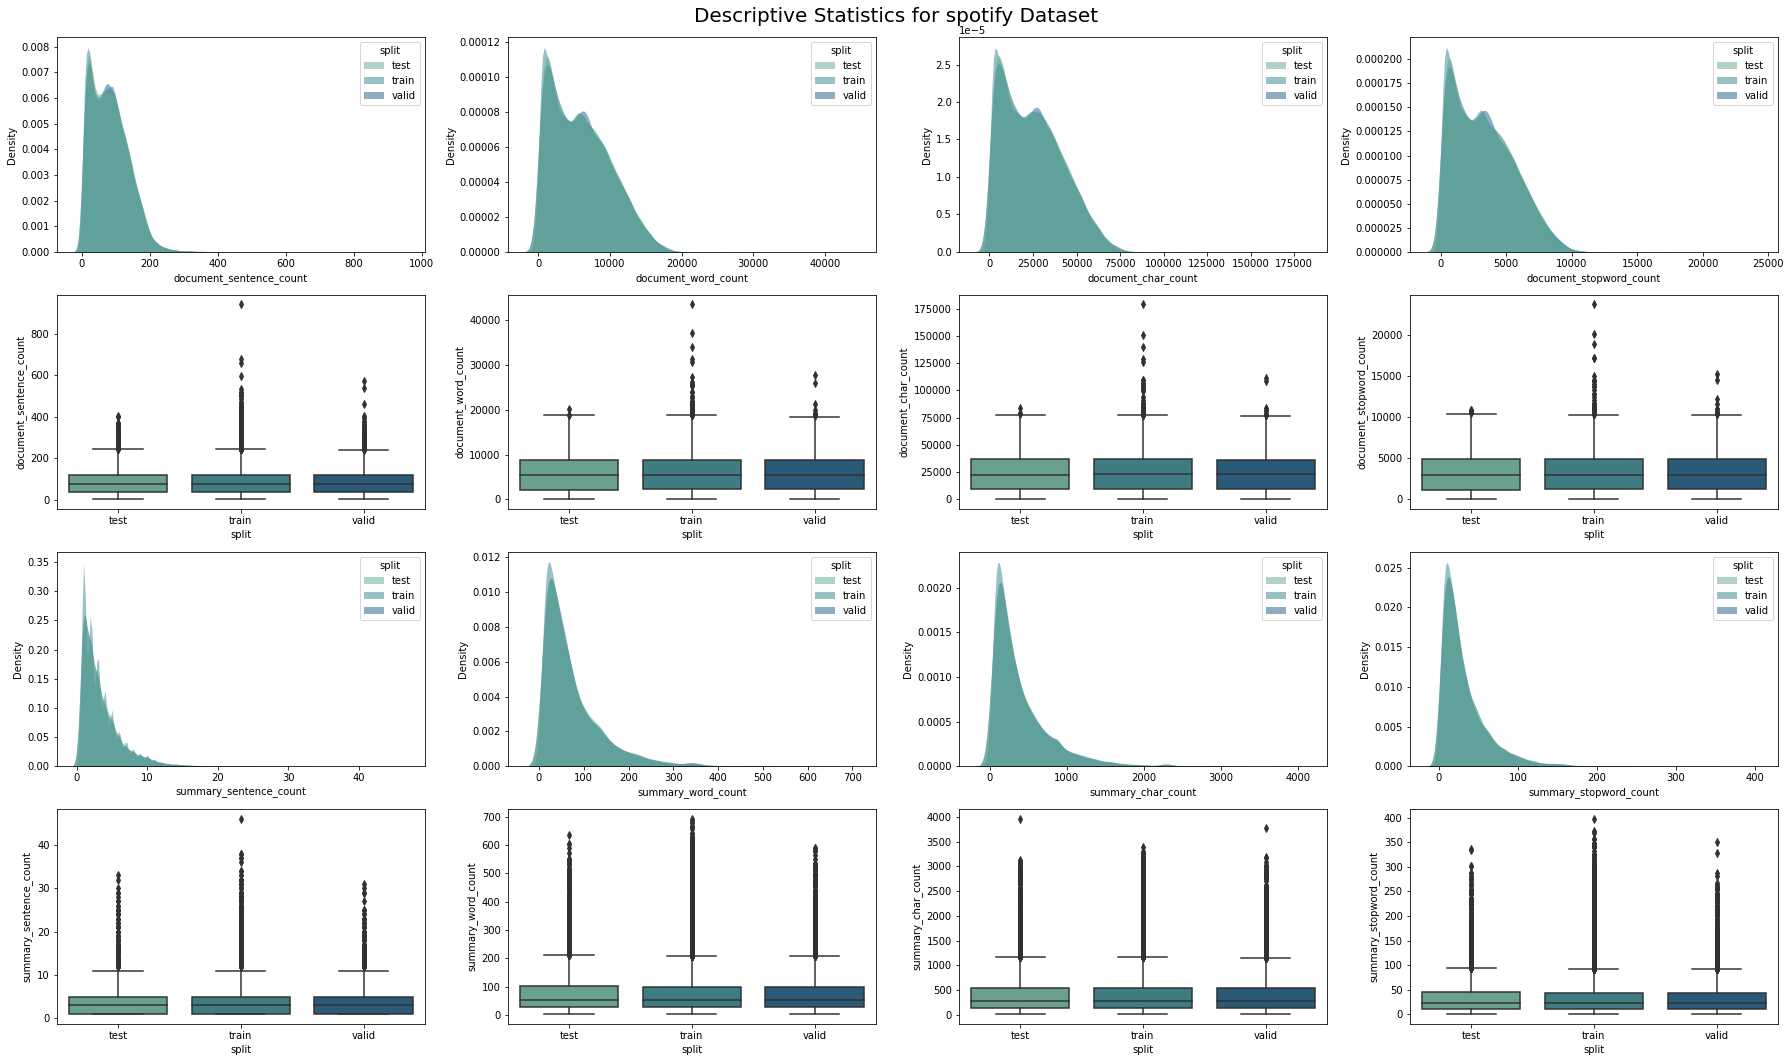

count     mean      std   min  \
spotify test  document char_count        9940.00 24565.97 17070.60 44.00   
                       sentence_count    9940.00    81.30    54.61  1.00   
                       sentence_density  9940.00     0.02     0.01  0.01   
                       stopword_count    9940.00  3240.10  2286.44  6.00   
                       word_count        9940.00  5863.79  4131.73 12.00   
              summary  char_count        9940.00   414.50   425.82 14.00   
                       sentence_count    9940.00     3.51     3.08  1.00   
                       sentence_density  9940.00     0.05     0.03  0.01   
                       stopword_count    9940.00    32.90    33.15  0.00   
                       word_count        9940.00    76.76    74.54  3.00   
        train document char_count       79173.00 24687.60 17132.94 55.00   
                       sentence_count   79173.00    81.67    55.41  1.00   
                       sentence_density 79173.00     0.02     0.01  0.01   
                       stopword_count   79173.00  3255.05  2297.73  3.00   
                       word_count       79173.00  5891.62  4148.81 12.00   
              summary  char_count       79173.00   409.57   415.77 11.00   
                       sentence_count   79173.00     3.50     3.07  1.00   
                       sentence_density 79173.00     0.05     0.03  0.00   
                       stopword_count   79173.00    32.76    33.02  0.00   
                       word_count       79173.00    76.06    73.56  3.00   
        valid document char_count        9952.00 24636.78 17129.77 65.00   
                       sentence_count    9952.00    81.56    55.16  1.00   
                       sentence_density  9952.00     0.02     0.01  0.01   
                       stopword_count    9952.00  3251.88  2297.59  1.00   
                       word_count        9952.00  5880.12  4145.02 14.00   
              summary  char_count        9952.00   409.38   414.50 17.00   
                       sentence_count    9952.00     3.50     3.05  1.00   
                       sentence_density  9952.00     0.05     0.02  0.00   
                       stopword_count    9952.00    32.60    32.18  0.00   
                       word_count        9952.00    75.85    72.51  3.00   

                                            25%      50%      75%       max  
spotify test  document char_count       9376.75 22713.50 36814.50  83724.00  
                       sentence_count     35.00    75.00   118.00    402.00  
                       sentence_density    0.01     0.01     0.02      0.47  
                       stopword_count   1199.75  2969.50  4887.00  10909.00  
                       word_count       2176.75  5402.00  8834.50  20175.00  
              summary  char_count        132.00   272.00   545.00   3963.00  
                       sentence_count      1.00     3.00     5.00     33.00  
                       sentence_density    0.04     0.05     0.06      0.33  
                       stopword_count     11.00    22.00    44.00    336.00  
                       word_count         27.00    53.00   101.00    636.00  
        train document char_count       9578.00 22893.00 36801.00 178902.00  
                       sentence_count     35.00    76.00   118.00    943.00  
                       sentence_density    0.01     0.01     0.02      0.54  
                       stopword_count   1231.00  2991.00  4882.00  23764.00  
                       word_count       2227.00  5421.00  8841.00  43504.00  
              summary  char_count        132.00   271.00   543.00   3391.00  
                       sentence_count      1.00     3.00     5.00     46.00  
                       sentence_density    0.04     0.05     0.06      0.33  
                       stopword_count     11.00    22.00    43.00    398.00  
                       word_count         27.00    53.00    99.00    692.00  
        valid document char_count       9647.00 

# Dataset Card Spotify Dataset

## Dataset Description

- **Homepage:** [Spotiyfy Home](https://podcastsdataset.byspotify.com)
- **Repository:** [Spotify Dataset](https://podcastsdataset.byspotify.com)

- **Point of Contact:** [Rosie Jones, Ben Carterette, Ann Clifton, Maria Eskevich, Gareth JF Jones, Jussi Karlgren, Aasish Pappu, Sravana Reddy, and Yongze Yu. "TREC 2020 Podcasts Track Overview." In the Twenty-Ninth Text REtrieval Conference Proceedings (TREC 2020). NIST Special Publication 1266. Ellen M. Voorhees and Angela Ellis (editors). 2021.
 ]()

### Dataset Summary

The podcast dataset contains about 100k podcasts filtered to contain only documents which the creator tags as being in the English language, as well as by a language filter applied to the creator-provided title and description. We expect that there will be a small amount of multilingual content that may have slipped through these filters.

Episodes were sampled from both professional and amateur podcasts including episodes produced in a studio with dedicated equipment by trained professionals, as well as episodes self-published from a phone app — these vary in quality depending on professionalism and equipment of the creator.

The episodes represent a wide range of:

Audio quality: we can expect professionally produced podcasts to have high audio quality, but there is significant variability in the amateur podcasts. We have included a basic popularity filter to remove most podcasts that are defective or noisy.
Topics: the episodes represent a wide range of topics, both coarse- and fine-grained. These include lifestyle and culture, storytelling, sports and recreation, news, health, documentary, and commentary.
Structural formats: podcasts are structured in a number of different ways. These include scripted and unscripted monologues, interviews, conversations, debate, and included clips of other non-speech audio material.



Each of the 100,000 episodes in the dataset includes an audio file, a text transcript, and some associated metadata.

Note that the data do not include listening data or other user or usage-related data.

The main data are separated into three top-level directories:
 
 
one for transcripts, one for RSS files, and one for audio data.
Since the audio files are vastly larger than the metadata, and not all researchers will choose to work on the audio data, we make these available for separate download.
The metadata can be found in a single csv file in the top-level directory.
In addition there are various annotations for the podcast data in separate directories. 
 
 
Audio directory:
 
OGG format available for separate download
Median duration of an episode ~ 31.6 minutes
Estimated size: ~2 TB for entire audio data set
 
 
Metadata:
 
Extracted basic metadata file in TSV format with fields: show_uri, show_name, show_description, publisher, language, rss_link, episode_uri, episode_name, episode_description, duration
 
Subdirectory for the episode RSS header files:
 
~1000 words with additional fields of potential interest, not necessarily aligned for every episode: channel, title, description, author, link, copyright, language, image
Estimated size: 145MB total for entire RSS set when compressed. 
 

Subdirectory for transcripts: 
 
JSON format
Average length is just under 6000 words, ranging from a small number of extremely short episodes to up to 45,000 words. Two-thirds of the transcripts are between about 1,000 and about 10,000 words in length; about 1% or 1,000 episodes are very short trailers to advertise other content. 
Estimated size: 12GB for entire transcript set.

Subdirectory for OpenSmile audio features 

eGeMAPS low level acoustic descriptors and functionals computed for overlapping 1.01s windows (75GB) saved in HDF5 format.

Subdirectory for Yamnet audio events 

1024-dimensional embedding vectors for overlapping 0.96s segments for the podcasts (400GB) and Yamnet event class scores (60GB), saved in HDF5 format.
 

### Supported Tasks and Model Measurement

The dataset can be used to train a model for Extractive and Abstractive summarization, which consists, select key sentences and phrases from the document and combine them into shorter forms and Abstractive summarization tries to understand the main content of the document and then explain them in clear natural language. Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(metric)).

### Languages

Datasets are limited to English as the primary language. 

## Dataset Structure

### Data Instances


```
<data>
    <items>
        <item name="item1">item1abc</item>
        <item name="item2">item2abc</item>
    </items>
</data>
```


### Data Fields

item1 = Description

item2 = Summary

### Data Splits

dataset splits into Train, Validation and Test datasets

|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |  6465664   |    811702    |    808169  |
| Average Sentence Length    |    82    |   82    |  82    |

## Dataset Creation

### Source Data

Tetadata and content of published podcast episodes


#### Who are the source language producers?

The previous Spoken Document Retrieval task at TREC: https://pdfs.semanticscholar.org/57ee/3a15088f2db36e07e3972e5dd9598b5284af.pdf

## Considerations for Using the Data

### Social Impact of Dataset

Contact the organizers: podcasts-challenge-organizers@spotify.com

#### Final Dataset

**Final dataset has below structure**

```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```


## Additional Information

### Licensing Information

[License](https://docs.google.com/forms/d/e/1FAIpQLSca2WJ45uamUWJ-C5HxHe7a9M1FuiSQPqukTjL8o-vthbQtnA/viewform) 

### Citation Information

```
100,000 Podcasts: A Spoken English Document Corpus” by Ann Clifton, Sravana Reddy, Yongze Yu, Aasish Pappu, Rezvaneh Rezapour, Hamed Bonab, Maria Eskevich, Gareth Jones, Jussi Karlgren, Ben Carterette, and Rosie Jones, COLING 2020
https://www.aclweb.org/anthology/2020.coling-main.519/

Bibtex:

@inproceedings{clifton-etal- 2020-100000,
    title = "100,000 Podcasts: A Spoken {E}nglish Document Corpus",
    author = "Clifton, Ann  and
      Reddy, Sravana  and
      Yu, Yongze  and
      Pappu, Aasish  and
      Rezapour, Rezvaneh  and
      Bonab, Hamed  and
      Eskevich, Maria  and
      Jones, Gareth  and
      Karlgren, Jussi  and
      Carterette, Ben  and
      Jones, Rosie",
    booktitle = "Proceedings of the 28th International Conference on Computational Linguistics",
    month = dec,
    year = "2020",
    address = "Barcelona, Spain (Online)",
    publisher = "International Committee on Computational Linguistics",
    url = "https://www.aclweb.org/ anthology/2020.coling-main.519 ",
    pages = "5903--5917",
    abstract = "Podcasts are a large and growing repository of spoken audio. As an audio format, podcasts are more varied in style and production type than broadcast news, contain more genres than typically studied in video data, and are more varied in style and format than previous corpora of conversations. When transcribed with automatic speech recognition they represent a noisy but fascinating collection of documents which can be studied through the lens of natural language processing, information retrieval, and linguistics. Paired with the audio files, they are also a resource for speech processing and the study of paralinguistic, sociolinguistic, and acoustic aspects of the domain. We introduce the Spotify Podcast Dataset, a new corpus of 100,000 podcasts. We demonstrate the complexity of the domain with a case study of two tasks: (1) passage search and (2) summarization. This is orders of magnitude larger than previous speech corpora used for search and summarization. Our results show that the size and variability of this corpus opens up new avenues for research.",
}
 
```


### Contributions

Thanks to [Ann Clifton, Sravana Reddy, Yongze Yu, Aasish Pappu, Rezvaneh Rezapour, Hamed Bonab, Maria Eskevich, Gareth Jones, Jussi Karlgren, Ben Carterette, and Rosie Jones, COLING 2020]()

**Train Data  Distribution**
-  81 sentences, 5891 words and 24687 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (943) and chars (more than 178902) are  away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are away from mean value and the standard deviation is   high.
Most summaries are composed by 4 sentence and the number of words is very close to 76
The number of chars are mostly between 400 and 410.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is a large number, we can consider removing them but it does not look a great deal. The count of words looks like right skewed distribution, 75% of rows in the range 99 words, 5 sentences and the count of char is a right skewed distribution. Complete data distribution is right skewed.

In [12]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/spotify/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/spotify/dataset_distribution.md"))

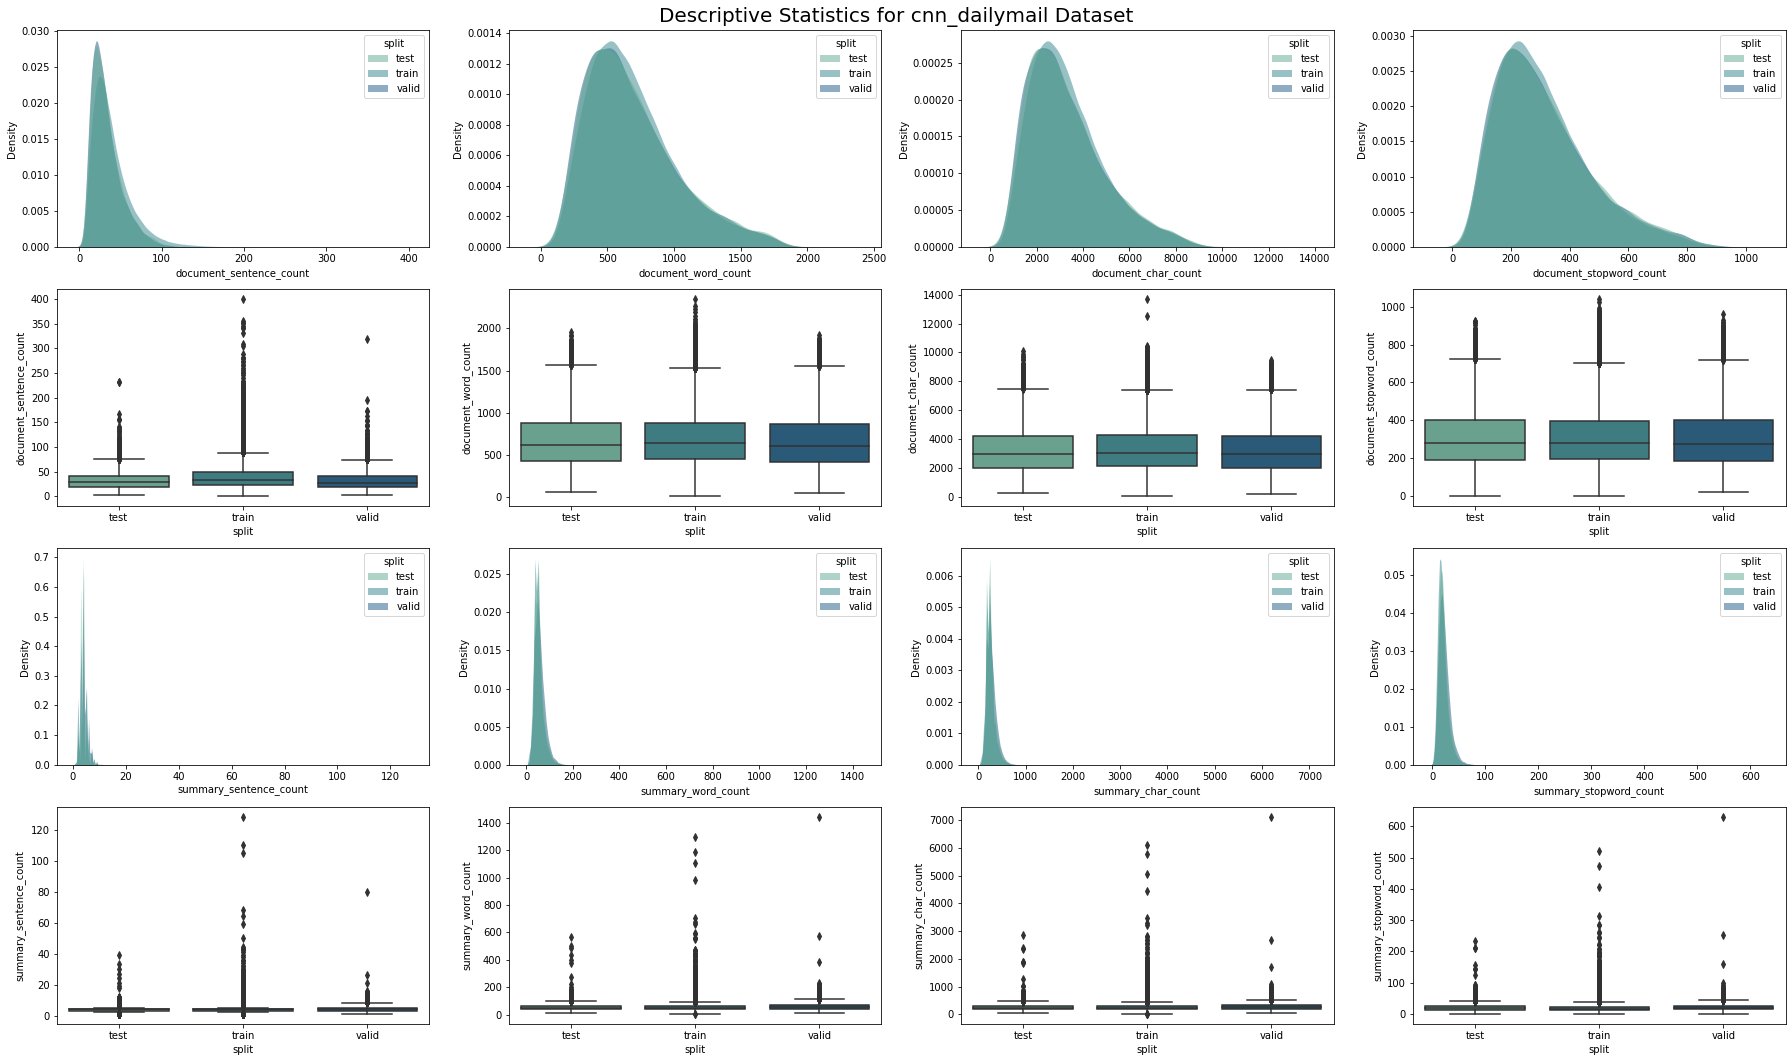

count    mean     std  \
cnn_dailymail test  document char_count        11490.00 3283.61 1677.66   
                             sentence_count    11490.00   33.37   18.97   
                             sentence_density  11490.00    0.05    0.01   
                             stopword_count    11490.00  311.67  163.06   
                             word_count        11490.00  683.53  348.41   
                    summary  char_count        11490.00  257.83  105.83   
                             sentence_count    11490.00    3.92    1.34   
                             sentence_density  11490.00    0.07    0.01   
                             stopword_count    11490.00   20.89   10.55   
                             word_count        11490.00   55.01   22.52   
              train document char_count       287113.00 3341.85 1619.20   
                             sentence_count   287113.00   39.10   23.58   
                             sentence_density 287113.00    0.06    0.01   
                             stopword_count   287113.00  308.80  156.15   
                             word_count       287113.00  691.89  336.51   
                    summary  char_count       287113.00  244.16   99.27   
                             sentence_count   287113.00    3.83    1.40   
                             sentence_density 287113.00    0.08    0.02   
                             stopword_count   287113.00   19.02    9.96   
                             word_count       287113.00   51.57   21.26   
              valid document char_count        13368.00 3247.72 1650.23   
                             sentence_count    13368.00   32.79   18.68   
                             sentence_density  13368.00    0.05    0.01   
                             stopword_count    13368.00  308.92  162.29   
                             word_count        13368.00  676.04  343.56   
                    summary  char_count        13368.00  271.01  120.98   
                             sentence_count    13368.00    4.15    1.52   
                             sentence_density  13368.00    0.07    0.01   
                             stopword_count    13368.00   22.14   11.90   
                             word_count        13368.00   57.91   25.61   

                                                 min     25%     50%     75%  \
cnn_dailymail test  document char_count       239.00 2010.00 2949.50 4199.00   
                             sentence_count     2.00   20.00   29.00   42.00   
                             sentence_density   0.02    0.04    0.05    0.05   
                             stopword_count     0.00  189.00  279.00  402.00   
                             word_count        55.00  419.00  613.00  876.00   
                    summary  char_count        42.00  185.00  240.00  297.00   
                             sentence_count     1.00    3.00    4.00    4.00   
                             sentence_density   0.03    0.07    0.08    0.08   
                             stopword_count     0.00   14.00   19.00   25.00   
                             word_count         9.00   40.00   51.00   64.00   
              train document char_count        41.00 2140.00 3049.00 4238.00   
                             sentence_count     1.00   23.00   33.00   49.00   
                             sentence_density   0.01    0.05    0.05    0.06   
                             stopword_count     0.00  193.00  280.00  396.00   
                             word_count         8.00  443.00  632.00  877.00   
                    summary  char_count        11.00  181.00  232.00  284.00   
                             sentence_count     1.00    3.00    4.00    4.00   
                             sentence_density   0.02    0.07    0.08    0.09   
                             stopword_count     0.00   13.00   17.00   23.00   
                             word_count         4.00   38.00   48.00   60.00   
              valid document char_count     

# Dataset Card CNN Dailymail data

## Dataset Description

- **Homepage:** [CNN Dailymail Home](https://huggingface.co/datasets/cnn_dailymail)
- **Repository:** [CNN Dailymail Github](https://github.com/abisee/cnn-dailymail)
- **Paper:** [Abstractive Text Summarization Using Sequence-to-Sequence RNNs and Beyond, Get To The Point: Summarization with Pointer-Generator Networks](_https://papers.nips.cc/paper/5945-teaching-machines-to-read-and-comprehend.pdf_)
- **Point of Contact:** [Abigail See](abisee@stanford.edu)

### Dataset Summary

The CNN / DailyMail Dataset is an English-language dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail. The current version supports both extractive and abstractive summarization, though the original version was created for machine reading and comprehension and abstractive question answering. 

### Supported Tasks and Leaderboards

- 'summarization': [Versions 2.0.0 and 3.0.0 of the CNN / DailyMail Dataset](https://www.aclweb.org/anthology/K16-1028.pdf) can be used to train a model for abstractive and extractive summarization ([Version 1.0.0](https://papers.nips.cc/paper/5945-teaching-machines-to-read-and-comprehend.pdf) was developed for machine reading and comprehension and abstractive question answering). The model performance is measured by how high the output summary's [ROUGE](https://huggingface.co/metrics/rouge) score for a given article is when compared to the highlight as written by the original article author. [Zhong et al (2020)](https://www.aclweb.org/anthology/2020.acl-main.552.pdf) report a ROUGE-1 score of 44.41 when testing a model trained for extractive summarization. See the [Papers With Code leaderboard](https://paperswithcode.com/sota/document-summarization-on-cnn-daily-mail) for more models.

### Languages

The BCP-47 code for English as generally spoken in the United States is en-US and the BCP-47 code for English as generally spoken in the United Kingdom is en-GB. It is unknown if other varieties of English are represented in the data.

## Dataset Structure

### Data Instances
For each instance, there is a string for the article, a string for the highlights, and a string for the id. See the [CNN / Daily Mail dataset viewer](https://huggingface.co/datasets/viewer/?dataset=cnn_dailymail&config=3.0.0) to explore more examples.

```
{'id': '0054d6d30dbcad772e20b22771153a2a9cbeaf62',
 'article': '(CNN) -- An American woman died aboard a cruise ship that docked at Rio de Janeiro on Tuesday, the same ship on which 86 passengers previously fell ill, according to the state-run Brazilian news agency, Agencia Brasil. The American tourist died aboard the MS Veendam, owned by cruise operator Holland America. Federal Police told Agencia Brasil that forensic doctors were investigating her death. The ship's doctors told police that the woman was elderly and suffered from diabetes and hypertension, according the agency. The other passengers came down with diarrhea prior to her death during an earlier part of the trip, the ship's doctors said. The Veendam left New York 36 days ago for a South America tour.'
 'highlights': 'The elderly woman suffered from diabetes and hypertension, ship's doctors say .\nPreviously, 86 passengers had fallen ill on the ship, Agencia Brasil says .'}
```

The average token count for the articles and the highlights are provided below:

| Feature    | Mean Token Count |
| ---------- | ---------------- |
| Article    | 781              |
| Highlights | 56               |


### Data Fields

- `id`: a string containing the heximal formated SHA1 hash of the url where the story was retrieved from
- `article`: a string containing the body of the news article 
- `highlights`: a string containing the highlight of the article as written by the article author

### Data Splits


The CNN/DailyMail dataset has 3 splits: _train_, _validation_, and _test_. Below are the statistics for Version 3.0.0 of the dataset.

| Dataset Split | Number of Instances in Split                |
| ------------- | ------------------------------------------- |
| Train         | 287,113                                     |
| Validation    | 13,368                                      |
| Test          | 11,490                                      |

|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |  11226186      |   483333    |    383416  |
| Average Sentence Length    |  39      |   32    |  33    |

## Dataset Creation

### Curation Rationale

Version 1.0.0 aimed to support supervised neural methodologies for machine reading and question answering with a large amount of real natural language training data and released about 313k unique articles and nearly 1M Cloze style questions to go with the articles. Versions 2.0.0 and 3.0.0 changed the structure of the dataset to support summarization rather than question answering. Version 3.0.0 provided a non-anonymized version of the data, whereas both the previous versions were preprocessed to replace named entities with unique identifier labels. 


### Source Data


#### Initial Data Collection and Normalization
The data consists of news articles and highlight sentences. In the question answering setting of the data, the articles are used as the context and entities are hidden one at a time in the highlight sentences, producing Cloze style questions where the goal of the model is to correctly guess which entity in the context has been hidden in the highlight. In the summarization setting, the highlight sentences are concatenated to form a summary of the article. The CNN articles were written between April 2007 and April 2015. The Daily Mail articles were written between June 2010 and April 2015. 

The code for the original data collection is available at <https://github.com/deepmind/rc-data>. The articles were downloaded using archives of <www.cnn.com> and <www.dailymail.co.uk> on the Wayback Machine. Articles were not included in the Version 1.0.0 collection if they exceeded 2000 tokens. Due to accessibility issues with the Wayback Machine, Kyunghyun Cho has made the datasets available at <https://cs.nyu.edu/~kcho/DMQA/>. An updated version of the code that does not anonymize the data is available at <https://github.com/abisee/cnn-dailymail>. 

Hermann et al provided their own tokenization script. The script provided by See uses the PTBTokenizer. It also lowercases the text and adds periods to lines missing them.

#### Who are the source language producers?

The text was written by journalists at CNN and the Daily Mail. 

### Annotations

The dataset does not contain any additional annotations.

### Personal and Sensitive Information

Version 3.0 is not anonymized, so individuals' names can be found in the dataset. Information about the original author is not included in the dataset.

## Considerations for Using the Data

### Social Impact of Dataset

The purpose of this dataset is to help develop models that can summarize long paragraphs of text in one or two sentences.

This task is useful for efficiently presenting information given a large quantity of text. It should be made clear that any summarizations produced by models trained on this dataset are reflective of the language used in the articles, but are in fact automatically generated.

### Discussion of Biases

[Bordia and Bowman (2019)](https://www.aclweb.org/anthology/N19-3002.pdf) explore measuring gender bias and debiasing techniques in the CNN / Dailymail dataset, the Penn Treebank, and WikiText-2. They find the CNN / Dailymail dataset to have a slightly lower gender bias based on their metric compared to the other datasets, but still show evidence of gender bias when looking at words such as 'fragile'.

Because the articles were written by and for people in the US and the UK, they will likely present specifically US and UK perspectives and feature events that are considered relevant to those populations during the time that the articles were published. 

### Other Known Limitations

News articles have been shown to conform to writing conventions in which important information is primarily presented in the first third of the article [(Kryściński et al, 2019)](https://www.aclweb.org/anthology/D19-1051.pdf). [Chen et al (2016)](https://www.aclweb.org/anthology/P16-1223.pdf) conducted a manual study of 100 random instances of the first version of the dataset and found 25% of the samples to be difficult even for humans to answer correctly due to ambiguity and coreference errors. 

It should also be noted that machine-generated summarizations, even when extractive, may differ in truth values when compared to the original articles. 
## Additional Information

### Dataset Curators

The data was originally collected by Karl Moritz Hermann, Tomáš Kočiský, Edward Grefenstette, Lasse Espeholt, Will Kay, Mustafa Suleyman, and Phil Blunsom of Google DeepMind. Tomáš Kočiský and Phil Blunsom are also affiliated with the University of Oxford. They released scripts to collect and process the data into the question answering format. 

Ramesh Nallapati, Bowen Zhou, Cicero dos Santos, and Bing Xiang of IMB Watson and Çağlar Gu̇lçehre of Université de Montréal modified Hermann et al's collection scripts to restore the data to a summary format. They also produced both anonymized and non-anonymized versions.

The code for the non-anonymized version is made publicly available by Abigail See of Stanford University, Peter J. Liu of Google Brain and Christopher D. Manning of Stanford University at <https://github.com/abisee/cnn-dailymail>. The work at Stanford University was supported by the DARPA DEFT ProgramAFRL contract no. FA8750-13-2-0040.

#### Final Data

**Final dataset has below structure**
```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```

### Licensing Information

The CNN / Daily Mail dataset version 1.0.0 is released under the [Apache-2.0 License](http://www.apache.org/licenses/LICENSE-2.0). 

### Citation Information

```
@inproceedings{see-etal-2017-get,
    title = "Get To The Point: Summarization with Pointer-Generator Networks",
    author = "See, Abigail  and
      Liu, Peter J.  and
      Manning, Christopher D.",
    booktitle = "Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)",
    month = jul,
    year = "2017",
    address = "Vancouver, Canada",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/P17-1099",
    doi = "10.18653/v1/P17-1099",
    pages = "1073--1083",
    abstract = "Neural sequence-to-sequence models have provided a viable new approach for abstractive text summarization (meaning they are not restricted to simply selecting and rearranging passages from the original text). However, these models have two shortcomings: they are liable to reproduce factual details inaccurately, and they tend to repeat themselves. In this work we propose a novel architecture that augments the standard sequence-to-sequence attentional model in two orthogonal ways. First, we use a hybrid pointer-generator network that can copy words from the source text via pointing, which aids accurate reproduction of information, while retaining the ability to produce novel words through the generator. Second, we use coverage to keep track of what has been summarized, which discourages repetition. We apply our model to the CNN / Daily Mail summarization task, outperforming the current abstractive state-of-the-art by at least 2 ROUGE points.",
}
```

```
@inproceedings{DBLP:conf/nips/HermannKGEKSB15,
  author={Karl Moritz Hermann and Tomás Kociský and Edward Grefenstette and Lasse Espeholt and Will Kay and Mustafa Suleyman and Phil Blunsom},
  title={Teaching Machines to Read and Comprehend},
  year={2015},
  cdate={1420070400000},
  pages={1693-1701},
  url={http://papers.nips.cc/paper/5945-teaching-machines-to-read-and-comprehend},
  booktitle={NIPS},
  crossref={conf/nips/2015}
}

```

### Contributions

Thanks to [@thomwolf](https://github.com/thomwolf), [@lewtun](https://github.com/lewtun), [@jplu](https://github.com/jplu), [@jbragg](https://github.com/jbragg), [@patrickvonplaten](https://github.com/patrickvonplaten) and [@mcmillanmajora](https://github.com/mcmillanmajora) for adding this dataset.


**Train Data  Distribution**
-  39 sentences, 691 words and 3341 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (399) and chars (more than 13680) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are close to mean value and the standard deviation is relatively  low.
Most summaries are composed by 3 sentence and the number of words is very close to 51
The number of chars are mostly between 240 and 250.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is a large number, we can consider removing them but it does not look a great deal. The count of words looks like normal distribution, 75% of rows in the range 60 words, 4 sentences and the count of char is a normal distribution. Complete data distribution is right skewed.

In [13]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/cnn_dailymail/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/cnn_dailymail/dataset_distribution.md"))

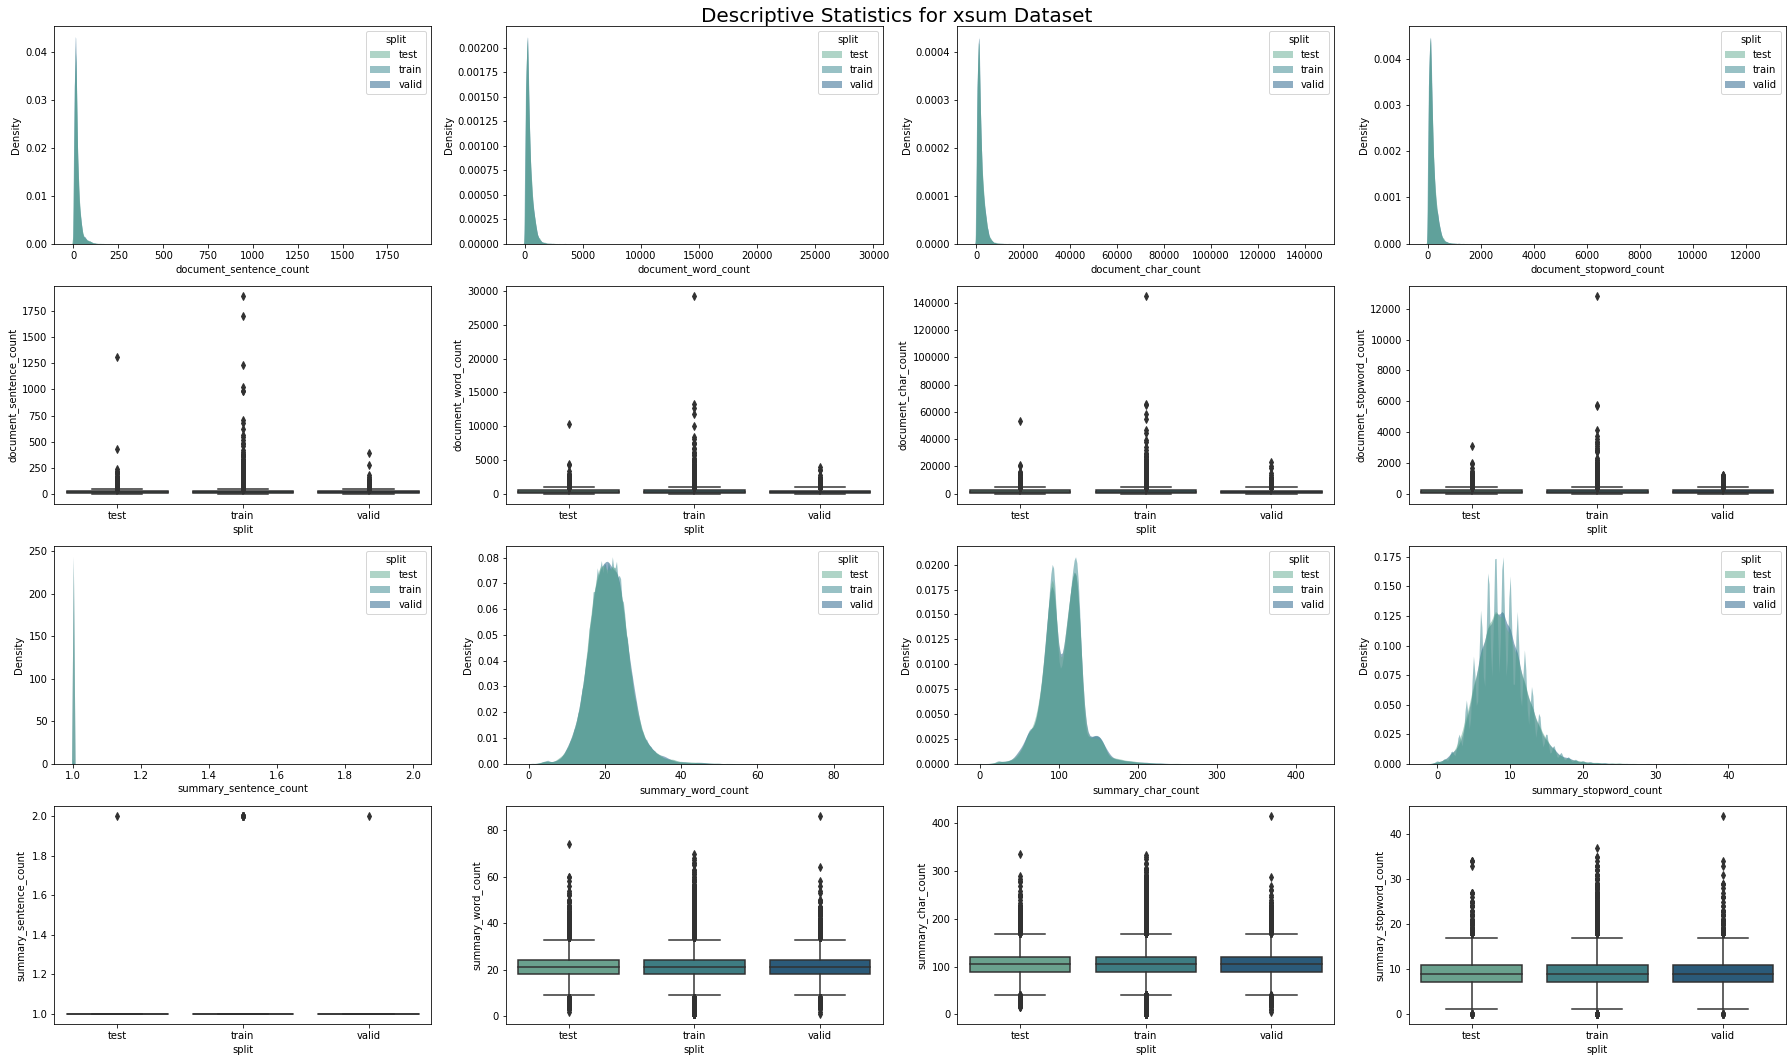

count    mean     std   min    25%  \
xsum test  document char_count        11334.00 1838.74 1509.82  0.00 876.00   
                    sentence_count    11334.00   20.00   21.84  0.00   9.00   
                    sentence_density  11334.00    0.05    0.02  0.00   0.05   
                    stopword_count    11334.00  171.81  142.25  0.00  79.00   
                    word_count        11334.00  376.15  308.25  0.00 179.00   
           summary  char_count        11334.00  105.29   25.66 15.00  89.00   
                    sentence_count    11334.00    1.00    0.01  1.00   1.00   
                    sentence_density  11334.00    0.05    0.02  0.01   0.04   
                    stopword_count    11334.00    8.95    3.34  0.00   7.00   
                    word_count        11334.00   21.10    5.32  2.00  18.00   
     train document char_count       204045.00 1828.80 1491.24  0.00 864.00   
                    sentence_count   204045.00   19.78   19.35  0.00   9.00   
                    sentence_density 204045.00    0.05    0.01  0.00   0.05   
                    stopword_count   204045.00  170.25  142.02  0.00  78.00   
                    word_count       204045.00  373.87  304.67  0.00 176.00   
           summary  char_count       204045.00  105.36   25.47  1.00  89.00   
                    sentence_count   204045.00    1.00    0.01  1.00   1.00   
                    sentence_density 204045.00    0.05    0.02  0.01   0.04   
                    stopword_count   204045.00    8.93    3.26  0.00   7.00   
                    word_count       204045.00   21.10    5.24  1.00  18.00   
     valid document char_count        11332.00 1805.28 1384.04  0.00 867.00   
                    sentence_count    11332.00   19.33   16.88  0.00   9.00   
                    sentence_density  11332.00    0.05    0.01  0.00   0.05   
                    stopword_count    11332.00  168.53  133.15  0.00  77.00   
                    word_count        11332.00  369.14  282.02  0.00 177.00   
           summary  char_count        11332.00  105.46   25.66  5.00  89.00   
                    sentence_count    11332.00    1.00    0.01  1.00   1.00   
                    sentence_density  11332.00    0.05    0.02  0.01   0.04   
                    stopword_count    11332.00    8.98    3.30  0.00   7.00   
                    word_count        11332.00   21.13    5.27  1.00  18.00   

                                         50%     75%       max  
xsum test  document char_count       1444.00 2411.75  53619.00  
                    sentence_count     15.00   24.00   1310.00  
                    sentence_density    0.05    0.06      0.50  
                    stopword_count    133.00  224.00   3115.00  
                    word_count        295.00  492.00  10316.00  
           summary  char_count        106.00  121.00    337.00  
                    sentence_count      1.00    1.00      2.00  
                    sentence_density    0.05    0.06      0.50  
                    stopword_count      9.00   11.00     34.00  
                    word_count         21.00   24.00     74.00  
     train document char_count       1447.00 2408.00 144825.00  
                    sentence_count     15.00   24.00   1895.00  
                    sentence_density    0.05    0.06      1.00  
                    stopword_count    133.00  223.00  12816.00  
                    word_count        295.00  491.00  29259.00  
           summary  char_count        106.00  121.00    333.00  
                    sentence_count      1.00    1.00      2.00  
                    sentence_density    0.05    0.06      1.00  
                    stopword_count      9.00   11.00     37.00  
                    word_count         21.00   24.00     70.00  
     valid document char_count       1432.00 2362.00  23408.00  
                    sentence_count     15.00   24.00    389.00  
                    sentence_density    0.05    0.06      0.28  
                    stopword_co

# Dataset Card Xsum Dataset

## Dataset Description

- **Homepage:** [XSum Home)](https://huggingface.co/datasets/xsum)
- **Repository:** [Xsum Github](https://github.com/huggingface/datasets/blob/master/datasets/xsum)


### Dataset Summary

The Extreme Summarization (XSum) dataset is a dataset for evaluation of abstractive single-document summarization systems. The goal is to create a short, one-sentence new summary answering the question “What is the article about?”. The dataset consists of 226,711 news articles accompanied with a one-sentence summary. The articles are collected from BBC articles (2010 to 2017) and cover a wide variety of domains (e.g., News, Politics, Sports, Weather, Business, Technology, Science, Health, Family, Education, Entertainment and Arts). The official random split contains 204,045 (90%), 11,332 (5%) and 11,334 (5) documents in training, validation and test sets, respectively.

### Supported Tasks and Leaderboards

Extractive and Abstractive Summarization: The dataset can be used to train a model for Extractive and Abstractive summarization, which consists, select key sentences and phrases from the document and combine them into shorter forms and Abstractive summarization tries to understand the main content of the document and then explain them in clear natural language. Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(metric)).


### Languages

The dataset is in English.

## Dataset Structure

### Data Instances

- **Size of downloaded dataset files:** 245.38 MB
- **Size of the generated dataset:** 507.60 MB
- **Total amount of disk used:** 752.98 MB

An example of 'validation' looks as follows.
```
{
    "document": "some-body",
    "id": "29750031",
    "summary": "some-sentence"
}
```

### Data Fields

he data fields are the same among all splits.

#### default
- `document`: a `string` feature.
- `summary`: a `string` feature.
- `id`: a `string` feature.

### Data Splits

| name  |train |validation|test |
|-------|-----:|---------:|----:|
|default|204045|     11332|11334|


## Dataset Creation

### Source Data

#### Final Data

**Final dataset has below structure**
```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```

### Citation Information


```
@article{Narayan2018DontGM,
  title={Don't Give Me the Details, Just the Summary! Topic-Aware Convolutional Neural Networks for Extreme Summarization},
  author={Shashi Narayan and Shay B. Cohen and Mirella Lapata},
  journal={ArXiv},
  year={2018},
  volume={abs/1808.08745}
}  
```

### Contributions

Thanks to [@thomwolf](https://github.com/thomwolf), [@lewtun](https://github.com/lewtun), [@mariamabarham](https://github.com/mariamabarham), [@jbragg](https://github.com/jbragg), [@lhoestq](https://github.com/lhoestq), [@patrickvonplaten](https://github.com/patrickvonplaten) for adding this dataset.

**Train Data  Distribution**
-  20 sentences, 373 words and 1828 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small.
- We observe that the maximum number of sentences (1895) and chars (more than 144825) are not far from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are not far from mean value and the standard deviation is relatively  low.
Most summaries are composed by 1 sentence and the number of words is very close to 2921
The number of chars are mostly between 100 and 110.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is not a large number, we can consider removing them but it does not look a great deal. The count of words looks like normal distribution, 75% of rows in the range 24 words, 1 sentence and the count of char is a normal distribution. Summary of Word count is also normally distributed.

In [14]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/xsum/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/xsum/dataset_distribution.md"))

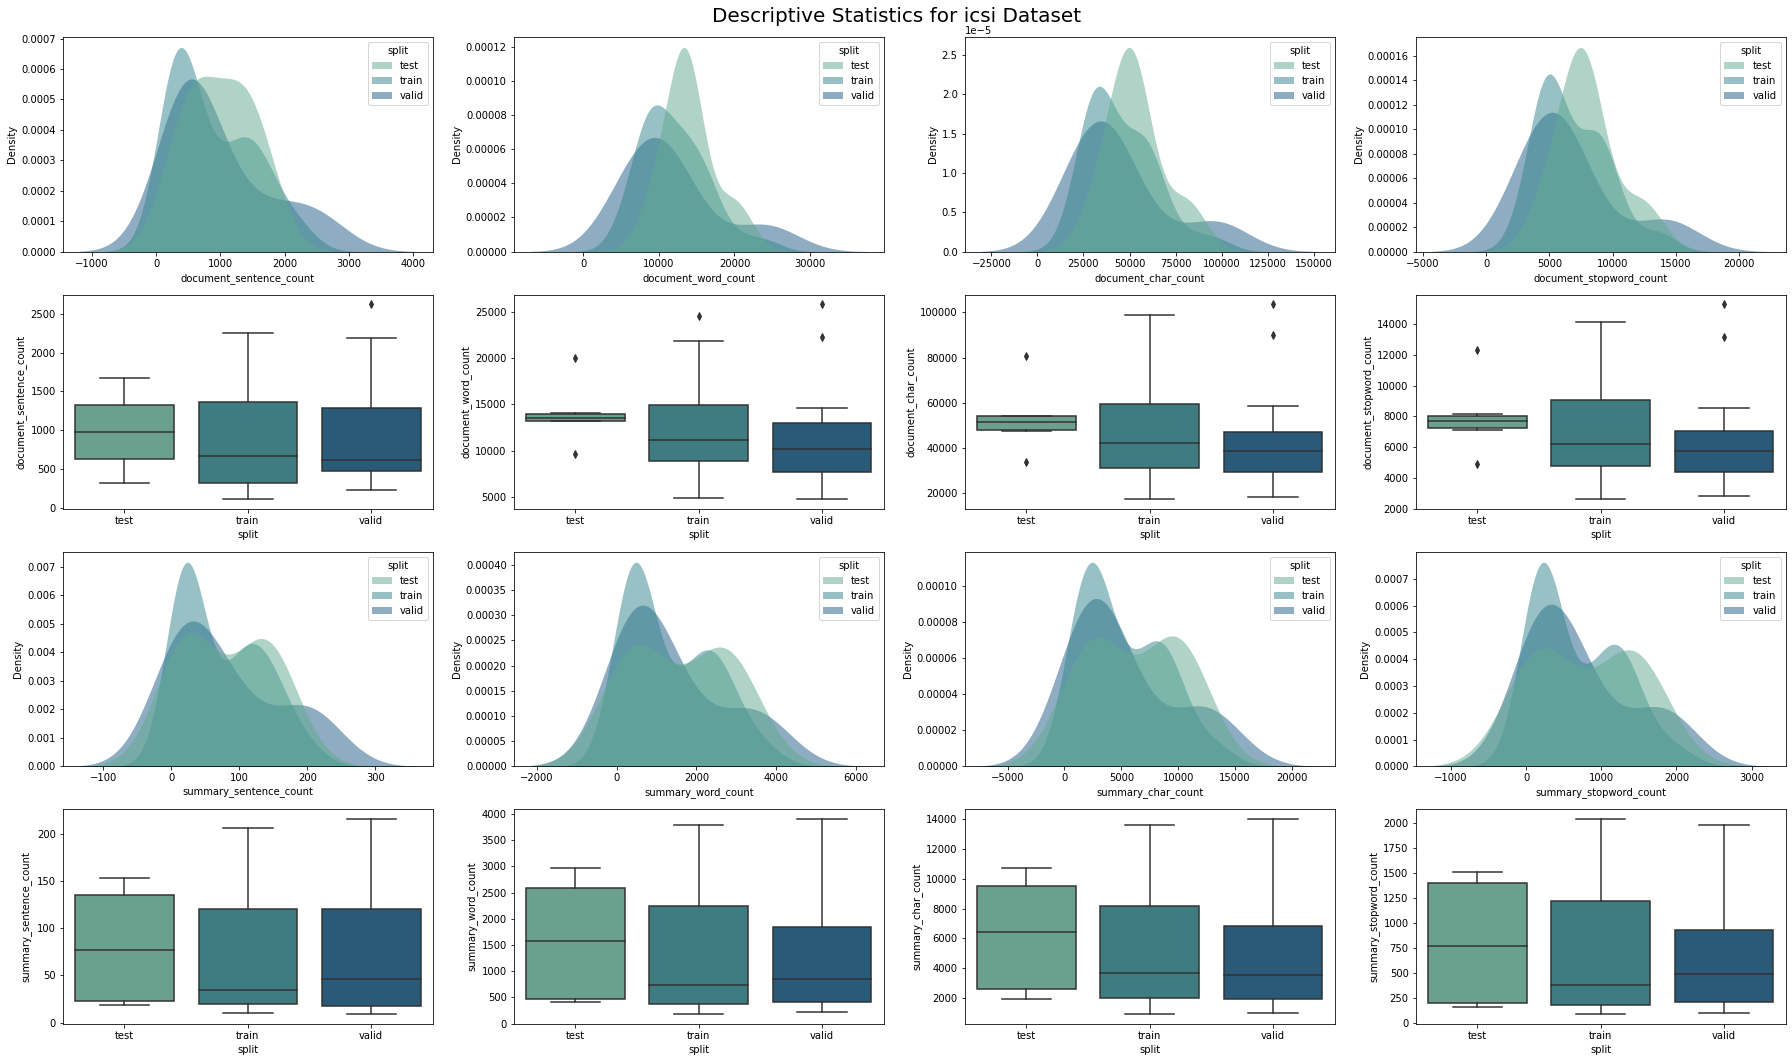

count     mean      std      min  \
icsi test  document char_count         6.00 53147.50 15395.26 33797.00   
                    sentence_count     6.00   984.83   513.62   325.00   
                    sentence_density   6.00     0.07     0.03     0.03   
                    stopword_count     6.00  7973.17  2406.22  4916.00   
                    word_count         6.00 13983.50  3370.01  9598.00   
           summary  char_count         6.00  6242.83  4058.40  1954.00   
                    sentence_count     6.00    81.00    64.03    19.00   
                    sentence_density   6.00     0.05     0.00     0.05   
                    stopword_count     6.00   804.67   671.72   161.00   
                    word_count         6.00  1591.17  1225.66   409.00   
     train document char_count        41.00 45582.49 18562.34 17258.00   
                    sentence_count    41.00   872.51   622.50   114.00   
                    sentence_density  41.00     0.07     0.03     0.02   
                    stopword_count    41.00  6841.12  2728.53  2627.00   
                    word_count        41.00 11993.10  4372.22  4859.00   
           summary  char_count        41.00  5130.56  3561.61   916.00   
                    sentence_count    41.00    73.07    59.10    10.00   
                    sentence_density  41.00     0.05     0.01     0.04   
                    stopword_count    41.00   687.00   563.35    88.00   
                    word_count        41.00  1335.20  1064.06   184.00   
     valid document char_count        12.00 45109.58 26685.19 18352.00   
                    sentence_count    12.00   970.83   777.92   231.00   
                    sentence_density  12.00     0.08     0.03     0.04   
                    stopword_count    12.00  6732.42  3870.65  2821.00   
                    word_count        12.00 11838.58  6402.64  4716.00   
           summary  char_count        12.00  5280.08  4538.13   988.00   
                    sentence_count    12.00    80.17    78.76     9.00   
                    sentence_density  12.00     0.05     0.01     0.04   
                    stopword_count    12.00   715.50   687.07    95.00   
                    word_count        12.00  1384.08  1304.38   218.00   

                                          25%      50%      75%       max  
icsi test  document char_count       47934.50 51378.50 53909.75  80791.00  
                    sentence_count     627.75   979.50  1323.75   1676.00  
                    sentence_density     0.04     0.07     0.09      0.10  
                    stopword_count    7243.00  7697.00  8031.00  12295.00  
                    word_count       13217.75 13510.00 13988.25  20015.00  
           summary  char_count        2610.50  6449.50  9525.00  10723.00  
                    sentence_count      23.25    76.50   135.00    154.00  
                    sentence_density     0.05     0.05     0.05      0.06  
                    stopword_count     200.75   770.00  1397.00   1510.00  
                    word_count         471.50  1568.50  2583.75   2973.00  
     train document char_count       31103.00 42209.00 59370.00  99034.00  
                    sentence_count     326.00   669.00  1362.00   2258.00  
                    sentence_density     0.03     0.06     0.10      0.11  
                    stopword_count    4804.00  6187.00  9033.00  14126.00  
                    word_count        8879.00 11158.00 14968.00  24596.00  
           summary  char_count        1977.00  3662.00  8181.00  13612.00  
                    sentence_count      20.00    35.00   121.00    207.00  
                    sentence_density     0.05     0.05     0.06      0.12  
                    stopword_count     183.00   374.00  1215.00   2037.00  
                    word_count         378.00   747.00  2239.00   3779.00  
     valid document char_count       29526.75 38586.50 46936.00 103541.00  
                    sentence_count     475.50   619.50  1286.25   2621.

# Dataset Card ICSI Data

## Dataset Description

- **Homepage:** [ICSI Home](http://www1.icsi.berkeley.edu/Speech/mr/)
- **Repository:** [ICSI download](https://groups.inf.ed.ac.uk/ami/icsi/download/)


### Dataset Summary

The ICSI Meeting Corpus is an audio data set consisting of about 70 hours of meeting recordings. More information can be found at the ICSI web site. To access the data, follow the directions given on the download page.

The audio was recorded on close-talking microphones - and available as either separate SPH files or a single mixed WAV file. Also available is orthographic transcription, and manual annotation of dialog acts and speech quality. Some third party annotations may also be made available here.

All of the signals and transcription, and some of the annotations, have been released publicly under the Creative Commons Attribution 4.0 International Licence (CC BY 4.0).

The collection includes 922 speech files, for a total of approximately 72 hours of Meeting Room speech. The speech is structured as one subdirectory per meeting, containing wavefiles for each channel (and possible .blp file, specifying any censored intervals).

The audio was collected at a 48 kHZ sample-rate, downsampled on the fly to 16 kHz. Audio files for each meeting are provided as separate time-synchronous recordings for each channel, encoded as 16-bit linear (big-endian) wavefiles, shorten-compressed in NIST SPHERE format.

The meetings were simultaneously recorded using close-talking microphones for each speaker (generally head-mounted, but early meetings contain some lapel microphones), as well as six table-top microphones: four high-quality omnidirectional PZM microphones arrayed down the center of the conference table, and two inexpensive microphone elements mounted on a mock PDA. All meetings were recorded in the same instrumented meeting room.

In addition to recording the meetings themselves, the participants were also asked to read digit strings, similar to those found in TIDIGITS, at the start or end of the meeting. This small-vocabulary read-speech component of the recordings -- using the same meeting room, speakers, and microphones -- provides a valuable supplement to the natural conversational data, allowing a factorization of the speech challenges offered by the corpus. For all but a dozen of the meetings included in the corpus, at least some of the participants read digit strings; for the great majority of meetings, all participants did. The digit readings are included as part of the wavefiles for the meeting as a whole and are fully transcribed as part of the associated transcripts.

There are a total of 53 unique speakers in the corpus. Meetings involved anywhere from three to 10 participants, averaging six. The corpus contains a significant proportion of non-native English speakers, varying in fluency from nearly-native to challenging-to-transcribe.

### Supported Tasks and Model measurement

Extractive and Abstractive Summarization: The dataset can be used to train a model for Extractive and Abstractive summarization, which consists, select key sentences and phrases from the document and combine them into shorter forms and Abstractive summarization tries to understand the main content of the document and then explain them in clear natural language. Success on this task is typically measured by [Rouge Score](https://en.wikipedia.org/wiki/ROUGE_(metric)).


### Languages

The dataset is available in english language

## Dataset Structure

### Data Instances


```
<data>
    <items>
        <item name="item1">item1abc</item>
        <item name="item2">item2abc</item>
    </items>
</data>
```



### Data Fields

- `item1` = Description

- `item2` = Summary

### Data Splits
dataset split into Train, Validation and Test data sets

  For example:


|                            | Tain   | Valid | Test |
| -----                      | ------ | ----- | ---- |
| Input Sentences            |  35773      |  11650     |  5909    |
| Average Sentence Length    |    882    |    970   |  984    |

## Dataset Creation

### Curation Rationale

What need motivated the creation of this dataset? What are some of the reasons underlying the major choices involved in putting it together?

### Source Data

This section describes the source data (e.g. news text and headlines, social media posts, translated sentences,...)

#### Initial Data Collection and Normalization

Describe the data collection process. Describe any criteria for data selection or filtering. List any key words or search terms used. If possible, include runtime information for the collection process.

If data was collected from other pre-existing datasets, link to source here and to their [Hugging Face version](https://huggingface.co/datasets/dataset_name).

If the data was modified or normalized after being collected (e.g. if the data is word-tokenized), describe the process and the tools used.

#### Who are the source language producers?

State whether the data was produced by humans or machine generated. Describe the people or systems who originally created the data.

If available, include self-reported demographic or identity information for the source data creators, but avoid inferring this information. Instead state that this information is unknown. See [Larson 2017](https://www.aclweb.org/anthology/W17-1601.pdf) for using identity categories as a variables, particularly gender.

Describe the conditions under which the data was created (for example, if the producers were crowdworkers, state what platform was used, or if the data was found, what website the data was found on). If compensation was provided, include that information here.

Describe other people represented or mentioned in the data. Where possible, link to references for the information.

### Annotations

Annotations are in [NXT format](http://groups.inf.ed.ac.uk/nxt/). To use with signals downloaded below, unzip one or both of these files into the 'amicorpus' directory. Requires NXT version 1.4.4.

[ICSI core annotations](http://groups.inf.ed.ac.uk/ami/ICSICorpusAnnotations/ICSI_core_NXT.zip)v1.0 22-July-2016 (19MB): transcripts plus dialogue act coding
[ICSI core plus contributed annotations](http://groups.inf.ed.ac.uk/ami/ICSICorpusAnnotations/ICSI_plus_NXT.zip) v1.0 (53MB): all the above plus third-party annotations for topic, hotspot, summarization etc.
[ICSI original MRT format transcripts with documentation](http://groups.inf.ed.ac.uk/ami/ICSICorpusAnnotations/ICSI_plus_NXT.zip) (4MB)
To use the signals below with NXT, download the Headset mix files, and unzip them into the directory where your ICSI-metadata.xml file is. Some programs assume the wav files are directly in the Signals directory, so you may need to use soft links to use those programs with audio.

#### Final Data

**Final dataset has below structure**
```
{"document": ["CHITTAGONG, Bangladesh: Roshen Silva joined the run fest in Chittagong to score his maiden Test century as Sri Lanka took a 99-run lead in the first Test against Bangladesh on Saturday (Feb 3).", "The visitors reached 612-4 at lunch on the fourth day as they eased past Bangladesh's first innings total of 513 at the Zahur Ahmed Chowdhury Stadium.", "Silva made 109 off 230 balls before he became the only batsman to be dismissed in the first session of the day after Sri Lanka resumed on 504-3.", "He was Sri Lanka's third centurion in the innings after Kusal Mendis and Dhananjaya de Silva, who made 196 and 173 runs respectively.", "Off-spinner Mehedi Hasan ended Silva's impressive innings as the right-hander edged a low delivery to wicketkeeper Liton Das.", "Silva shared a 135-run stand with skipper Dinesh Chandimal for the fourth wicket and hit 6 fours and a six.", "Advertisement", "Advertisement", "Chandimal closed in on his 11 Test century and fifth against Bangladesh to remain unbeaten on 87 at the break.", "Wicketkeeper-batsman Niroshan Dickwella was accompanying him at the crease with 29 not out.", "Bangladesh had the chance to dismiss Chandimal on 79 but Liton dropped a catch down the leg side off Mehedi.", "The off-spinner himself was at fault a few overs later when he could not get his hand onto an edge offered by Dickwella off Taijul Islam as the ball raced for four.", "Dickwella made Bangladesh pay for the miss as he hit the next two balls also for four with his last boundary taking Sri Lanka past 600 runs.", "Sri Lanka will now look to consolidate their lead to press for victory on a wearing pitch that has started showing encouraging signs for their spinners."], "summary": ["Cricket: Silva hits maiden ton as Sri Lanka build lead"]}
```

### Other Known Limitations

If studies of the datasets have outlined other limitations of the dataset, such as annotation artifacts, please outline and cite them here.

## Additional Information

### Licensing Information

The ICSI corpus and its annotations are released under the Creative
Commons Attribution 4.0 license agreement (also called CC BY 4.0).
Use of this data implies agreement with the terms below. See also:
http://creativecommons.org/licenses/by/4.0/legalcode

### Citation Information
```
@@INPROCEEDINGS{Mccowan05theami,
    author = {I. Mccowan and G. Lathoud and M. Lincoln and A. Lisowska and W. Post and D. Reidsma and P. Wellner},
    title = {The AMI Meeting Corpus},
    booktitle = {In: Proceedings Measuring Behavior 2005, 5th International Conference on Methods and Techniques in Behavioral Research. L.P.J.J. Noldus, F. Grieco, L.W.S. Loijens and P.H. Zimmerman (Eds.), Wageningen: Noldus Information Technology},
    year = {2005}
}
```

**Train Data  Distribution**
-  872 sentences, 11993 words and 45582 characters per row are the mean values and they are  close to the median values.
- Standard deviations are  small, but not too small.
- We observe that the maximum number of sentences (2258) and chars (more than 99034) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

**Train Data Summary Distribution**

The distribution of words and sentences are far from mean value and the standard deviation is relatively  high.
Most summaries are composed by 73 sentence and the number of words is very close to 1335
The number of chars are mostly between 5125 and 5135.
There are few records with large values. Outliers is not a problem, we can remove them.

**Data Visualization**

The count of rows with outliers values is a large number, we can consider removing them but it does not look a great deal. The count of words looks like normal distribution, 75% of rows in the range 2239 words, 121 sentences and the count of char is a normal distribution.

In [24]:
dataset_subset, name, dataset_subset_description = next(visualizations)
show_data_dists(dataset_subset, name)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(dataset_subset_description)
display(Markdown("datasets/raw/supervised/summarization/icsi/dataset_card.md"))
display(Markdown("datasets/raw/supervised/summarization/icsi/dataset_distribution.md"))

## Baseline

In [15]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")


def summarize_examples(examples):
    docs = nlp.pipe([" ".join(document) for document in examples["document"]])
    output_summaries = []
    for doc, summary in zip(docs, examples["summary"]):
        output_summary = doc._.textrank.summary(limit_sentences=len(summary))
        output_summaries.append([item.text for item in output_summary])
    return {"predicted_summary": output_summaries}

In [ ]:
def stringify_summaries(examples):
    return {"summary": ["\n".join(document) for document in examples["summary"]],
            "predicted_summary": ["\n".join(document) for document in examples["predicted_summary"]],
            }


data_splits = load_data_splits_from_dir(RAW_SUMMARIZATION_DATASETS_BUCKET_DIR)
features = datasets.features.Features({
    'document': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
    'summary': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
})

baseline_scores = {}
for name, splits in tqdm(data_splits.items()):
    metric = datasets.load_metric("rouge")


    def compute_rouge(examples):
        result = metric.add_batch(predictions=examples["predicted_summary"], references=examples["summary"])
        return examples


    test_dataset = datasets.load_dataset("json", name, data_files={"test": splits["test"]}, features=features, )["test"]
    test_dataset = test_dataset.map(summarize_examples, batched=True)
    test_dataset = test_dataset.map(stringify_summaries, batched=True, remove_columns=test_dataset.column_names)

    test_dataset = test_dataset.map(compute_rouge, batched=True, )
    # test_dataset = test_dataset.to_pandas()
    baseline_scores[name] = metric.compute(use_stemmer=True)


In [ ]:
scores = {}
for dataset, baseline in baseline_scores.items():

    # print(dict(baseline))
    for k, v in baseline.items():
        scores[(dataset, k, "low",)] = {"fmeasure": v.low.fmeasure, "recall": v.low.recall,
                                        "precision": v.low.precision}

        scores[(dataset, k, "mid",)] = {"fmeasure": v.mid.recall, "recall": v.mid.recall, "precision": v.mid.precision}
        scores[(dataset, k, "high",)] = {"fmeasure": v.high.recall, "precision": v.high.precision,
                                         "recall": v.high.recall}

baseline_scores = pd.DataFrame(scores).T
display(HTML(baseline_scores.to_html()))

baseline_scores.to_json(
    "/Users/bebop/Documents/courses/APCOMP215/AC215_projectgarble/datasets/raw/supervised/summarization/baseline_scores.json")

### Metrics

#### Rouge Metric

We use the rouge metric for evaluation of the baseline model and summary.

ref: https://en.wikipedia.org/wiki/ROUGE_(metric)

> ROUGE, or Recall-Oriented Understudy for Gisting Evaluation,[1] is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.




In [26]:
baseline_scores = pd.read_json("datasets/raw/supervised/summarization/baseline_scores.json")
baseline_scores = baseline_scores.set_index(baseline_scores.index.map(ast.literal_eval))
display(HTML(baseline_scores.to_html()))

### Models and Datasets

- The baseline model - TextRank performs well on the extractive summarization datasets such as AMI and ICSI
- When the summary length is short the model shows poor performance.
- In speech related datasets(ami, icsi, ted and spotify) the model performs poorly.